


`Grupo: `
* Andriel
* Enzo
* Hugo
* Marcos
* Pedro Mundel

Imagine que, em um dado projeto de pesquisa fictício, a empresa trouxe o arquivo "dataset.csv". A empresa informou que os dados contêm informações sobre o estado de saúde de 303 pacientes que apresentaram algum tipo de dor no peito, assim como o posterior resultado do exame de angiografia de cada um desses pacientes informando a presença ('Yes') ou ausência ('No') de uma determinada doença cardíaca.

# Exercício 1:

1.1 - O exame de angiografia é extremamente invasivo e perigoso para os pacientes. Desenvolva um modelo baseado em uma árvore de decisão para tentar detectar a doença cardíaca relacionada ao dataset. No desenvolvimento desse modelo, apresente um gráfico de *taxa de erro do modelo* vs *profundidade máxima da árvore*. Nesse gráfico, plote as curvas com os resultados para os splits de treino, teste e para o procedimento de cross-validation com 5 folds. Use esse gráfico para justiticar a profundidade máxima escolhida para o modelo final. (Bônus: apresente estimativas de incertezas para cada ponto das curvas apresentadas acima).

1.2 - Caso a empresa queira montar uma campanha de prevenção da doença, a partir do modelo obtido em 1.1, apresente dois cenários de características de pacientes modelo para a campanha: um cenário ideal com as características para um paciente com chances máximas de estar saudável; e um cenário pessimista com as características para um paciente com chances máximas de ter a doença.


# Exercício 2:

2.1 - Refaça o procedimento do exercício 1.1 para um modelo baseado em *Random Forests*. A profundidade máxima obtida para esse essemble é menor, igual ou maior à profundidade máxima obtida no exercício anterior? Isso corresponde ao esperado, dado as diferenças dos algoritmos avaliados?

2.2 - Para o modelo desenvolvido no item 2.1, quais são as características mais importantes (em ordem) para avaliar a saúde dos pacientes? Essas características estão relacionadas com os cenários apresentados no item 1.2?

# Bibliotecas Utilizadas

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 7.3 MB/s eta 0:00:00


In [49]:
import shap
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
from six import StringIO
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import graphviz


# Dicionario dos Dados

A `angiografia`, também conhecida como arteriografia, é um exame médico que utiliza raios X e um meio de contraste para visualizar e analisar os vasos sanguíneos do corpo. Este exame é indicado para o diagnóstico de várias condições, como aneurismas, obstruções, coágulos e outras anormalidades nos vasos sanguíneos. A angiografia pode ser realizada em várias partes do corpo, dependendo da doença que o médico está tentando diagnosticar. O procedimento começa com a introdução de um cateter em uma veia de maior calibre do corpo, geralmente no pescoço ou na virilha. Após a injeção do contraste, o médico adquire várias radiografias da área de interesse. Embora seja um exame muito informativo, a angiografia é considerada um procedimento invasivo e, portanto, deve ser realizada com cuidado.



---



* **Vazia**: 0: Uma coluna de índice.

* **Age**: Idade do paciente. A idade é um fator importante na avaliação do risco de doenças cardíacas, com o risco aumentando conforme a pessoa envelhece.

* **Sex**: Sexo do paciente.

* **ChestPain**: Tipo de dor no peito experimentada pelo paciente. Os tipos incluem:

    >`typical`: Dor no peito típica de angina.

    >`asymptomatic`: Sem sintomas de dor no peito, mas com doença cardíaca presente.

    >`nonanginal`: Dor no peito que não se enquadra na descrição de angina.

    >`nontypical`: Dor no peito que é atípica, não se encaixando nas categorias tradicionais de angina.

    >Este campo é crucial para diagnósticos preliminares, pois diferentes tipos de dor no peito podem indicar distintas condições cardíacas.

* **RestBP**: A pressão arterial em repouso (medida em mm Hg). A hipertensão, ou pressão arterial alta, é um fator de risco significativo para doenças cardíacas.

* **Chol**: Nível de colesterol sérico em mg/dl. Níveis elevados de colesterol são um fator de risco conhecido para doenças cardíacas, especialmente quando se trata de colesterol LDL ("ruim").

* **Fbs (Fast Blood Sugar)**: Açúcar no sangue em jejum > 120 mg/dl é considerado positivo (`1 = verdadeiro`), indicando possível diabetes. O diabetes é um fator de risco para doenças cardíacas.

* **RestECG**: Resultados eletrocardiográficos em repouso (`valores 0 como normal, 1 como preocupanete e 2 como serio`).

* **MaxHR**: A frequência cardíaca máxima alcançada durante algum teste de estresse.

* **ExAng (Exercise Induced Angina)**: Angina induzida por exercício (`1 = sim; 0 = não`). A ocorrência de angina durante o exercício é um forte indicador de doença arterial coronariana.

* **Oldpeak**: Este é um indicador de isquemia miocárdica durante um esforço.

* **Slope**: Pode indicar a severidade da isquemia cardíaca por niveis (`1,2,3`)

* **Ca**: Número de vasos principais coloridos por fluoroscopia..

* **Thal**: Um teste de stress com talio que pode ter três resultados:

    >`fixed`: Defeito fixo (sem mudança com o exercício).

    >`normal`: Sem defeitos visíveis.

    >`reversable`: Defeito reversível (anormalidades vistas apenas durante o exercício).

    >O teste de Thal é usado para diagnosticar a doença arterial coronariana e outras condições cardíacas.

* **AHD**: Presença de doença cardíaca (`Yes = presente; No = ausente`).



---



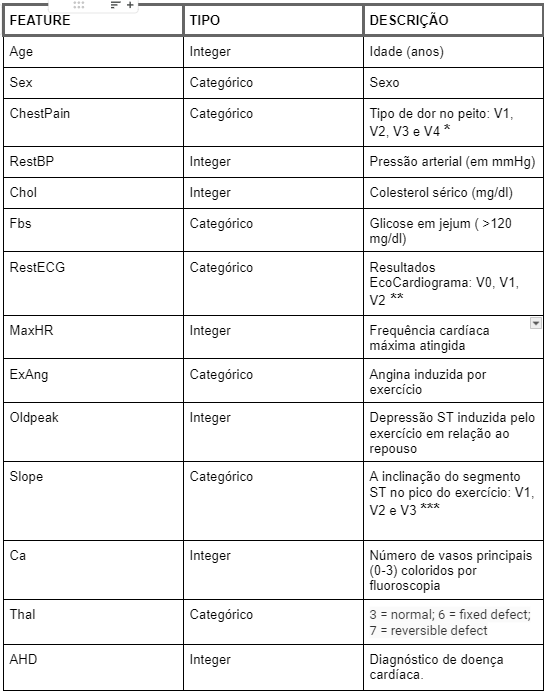

# Analise Exploratoria

In [3]:
# carregar o dataset
file_path = '/content/dataset (2).csv'
df = pd.read_csv(file_path)

In [4]:
df.head(10)

Unnamed: 0  Age  Sex     ChestPain  RestBP  Chol  Fbs  RestECG  MaxHR  \
0           1   63    1       typical     145   233    1        2    150   
1           2   67    1  asymptomatic     160   286    0        2    108   
2           3   67    1  asymptomatic     120   229    0        2    129   
3           4   37    1    nonanginal     130   250    0        0    187   
4           5   41    0    nontypical     130   204    0        2    172   
5           6   56    1    nontypical     120   236    0        0    178   
6           7   62    0  asymptomatic     140   268    0        2    160   
7           8   57    0  asymptomatic     120   354    0        0    163   
8           9   63    1  asymptomatic     130   254    0        2    147   
9          10   53    1  asymptomatic     140   203    1        2    155   

   ExAng  Oldpeak  Slope   Ca        Thal  AHD  
0      0      2.3      3  0.0       fixed   No  
1      1      1.5      2  3.0      normal  Yes  
2      1      2.6      2  2.0  reversable  Yes  
3      0      3.5      3  0.0      normal   No  
4      0      1.4      1  0.0      normal   No  
5      0      0.8      1  0.0      normal   No  
6      0      3.6      3  2.0      normal  Yes  
7      1      0.6      1  0.0      normal   No  
8      0      1.4      2  1.0  reversable  Yes  
9      1      3.1      3  0.0  reversable  Yes

In [5]:
# dimensão do dataset
df.shape

(303, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  303 non-null    int64  
 1   Age         303 non-null    int64  
 2   Sex         303 non-null    int64  
 3   ChestPain   303 non-null    object 
 4   RestBP      303 non-null    int64  
 5   Chol        303 non-null    int64  
 6   Fbs         303 non-null    int64  
 7   RestECG     303 non-null    int64  
 8   MaxHR       303 non-null    int64  
 9   ExAng       303 non-null    int64  
 10  Oldpeak     303 non-null    float64
 11  Slope       303 non-null    int64  
 12  Ca          299 non-null    float64
 13  Thal        301 non-null    object 
 14  AHD         303 non-null    object 
dtypes: float64(2), int64(10), object(3)
memory usage: 35.6+ KB


In [7]:
nulos_por_coluna = df.isnull().sum()
nulos_por_coluna

Unnamed: 0    0
Age           0
Sex           0
ChestPain     0
RestBP        0
Chol          0
Fbs           0
RestECG       0
MaxHR         0
ExAng         0
Oldpeak       0
Slope         0
Ca            4
Thal          2
AHD           0
dtype: int64

In [8]:
df.describe()

Unnamed: 0         Age         Sex      RestBP        Chol         Fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean   152.000000   54.438944    0.679868  131.689769  246.693069    0.148515   
std     87.612784    9.038662    0.467299   17.599748   51.776918    0.356198   
min      1.000000   29.000000    0.000000   94.000000  126.000000    0.000000   
25%     76.500000   48.000000    0.000000  120.000000  211.000000    0.000000   
50%    152.000000   56.000000    1.000000  130.000000  241.000000    0.000000   
75%    227.500000   61.000000    1.000000  140.000000  275.000000    0.000000   
max    303.000000   77.000000    1.000000  200.000000  564.000000    1.000000   

          RestECG       MaxHR       ExAng     Oldpeak       Slope          Ca  
count  303.000000  303.000000  303.000000  303.000000  303.000000  299.000000  
mean     0.990099  149.607261    0.326733    1.039604    1.600660    0.672241  
std      0.994971   22.875003    0.469794    1.161075    0.616226    0.937438  
min      0.000000   71.000000    0.000000    0.000000    1.000000    0.000000  
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000  
50%      1.000000  153.000000    0.000000    0.800000    2.000000    0.000000  
75%      2.000000  166.000000    1.000000    1.600000    2.000000    1.000000  
max      2.000000  202.000000    1.000000    6.200000    3.000000    3.000000

>>>* Idade: A idade média dos pacientes é de aproximadamente 54 anos, com um mínimo de 29 e um máximo de 77 anos.
* Sexo: Aproximadamente 68% dos pacientes são do sexo 1.
* Pressão Arterial em Repouso (RestBP): A média é de cerca de 132, variando de 94 a 200 mmHg.
* Colesterol (Chol): O colesterol sérico médio é de aproximadamente 247 mg/dl, com valores variando de 126 a 564 mg/dl.
* Açúcar no Sangue em Jejum (Fbs > 120 mg/dl): Cerca de 15% dos pacientes têm açúcar no sangue em jejum maior que 120 mg/dl.
* Frequência Cardíaca Máxima (MaxHR): A média é de aproximadamente 150 bpm, com um intervalo de 71 a 202 bpm.
* Angina Induzida por Exercício (ExAng): Aproximadamente 33% dos pacientes experimentaram angina induzida por exercício.
* Depressão de ST (Oldpeak): A média de depressão do ST é de aproximadamente 1,04, com um intervalo de 0 a 6,2.
* Número de Vasos Principais Coloridos por Fluoroscopia (Ca): A média é de cerca de 0,67, indicando que a maioria dos pacientes tem poucos vasos principais visíveis.

In [9]:
#colunas presentes no nosso dataset
df.columns

Index(['Unnamed: 0', 'Age', 'Sex', 'ChestPain', 'RestBP', 'Chol', 'Fbs',
       'RestECG', 'MaxHR', 'ExAng', 'Oldpeak', 'Slope', 'Ca', 'Thal', 'AHD'],
      dtype='object')

In [10]:
# tipos dos dados
df.dtypes

Unnamed: 0      int64
Age             int64
Sex             int64
ChestPain      object
RestBP          int64
Chol            int64
Fbs             int64
RestECG         int64
MaxHR           int64
ExAng           int64
Oldpeak       float64
Slope           int64
Ca            float64
Thal           object
AHD            object
dtype: object

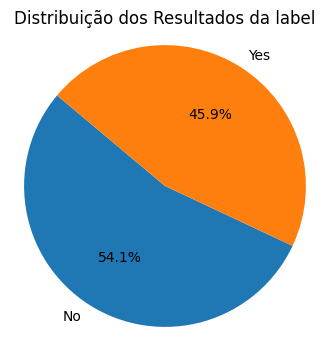

In [11]:
# contagem
cont_target = df['AHD'].value_counts()

# plot
plt.figure(figsize=(4, 4))
plt.pie(cont_target, labels=cont_target.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title("Distribuição dos Resultados da label")
plt.show()

In [12]:
# verificação de dados duplicados
print(df.duplicated(keep='first').any(), '\n')

False 



In [13]:
# valores únicos dos atributos categóricos
categorical_features = df.select_dtypes(include=['object']).columns.to_list()
for feature in categorical_features:
  unique_values = df[feature].unique().tolist()
  print(f'> {feature}')
  print(f'São {len(unique_values)} dados unicos para {feature}')
  print('\n')

> ChestPain
São 4 dados unicos para ChestPain


> Thal
São 4 dados unicos para Thal


> AHD
São 2 dados unicos para AHD




In [14]:
# valores unicos para todas os tipos de dados
df.nunique()

Unnamed: 0    303
Age            41
Sex             2
ChestPain       4
RestBP         50
Chol          152
Fbs             2
RestECG         3
MaxHR          91
ExAng           2
Oldpeak        40
Slope           3
Ca              4
Thal            3
AHD             2
dtype: int64

<Figure size 1500x800 with 0 Axes>

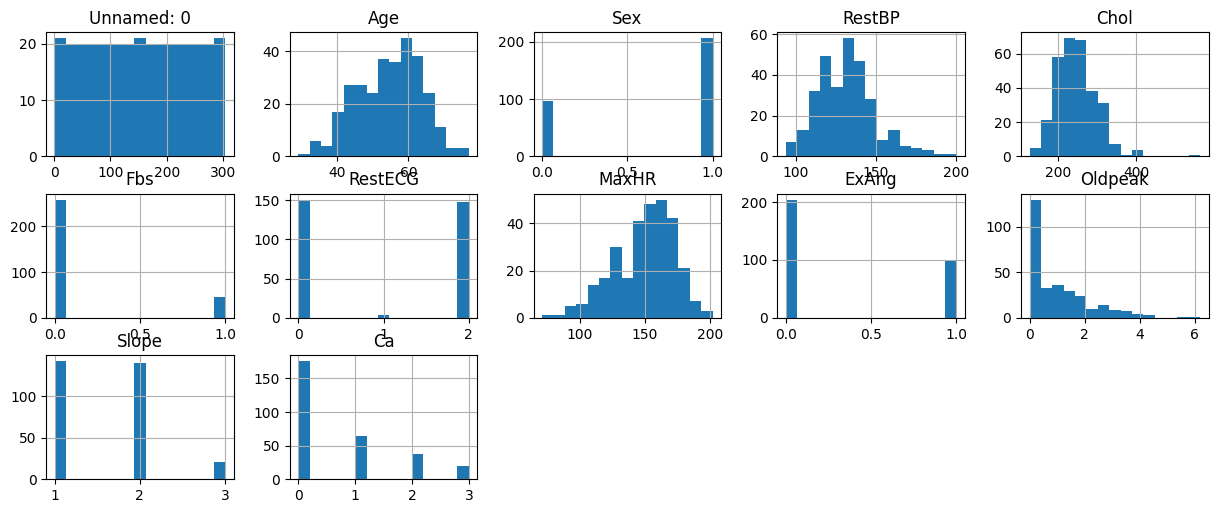

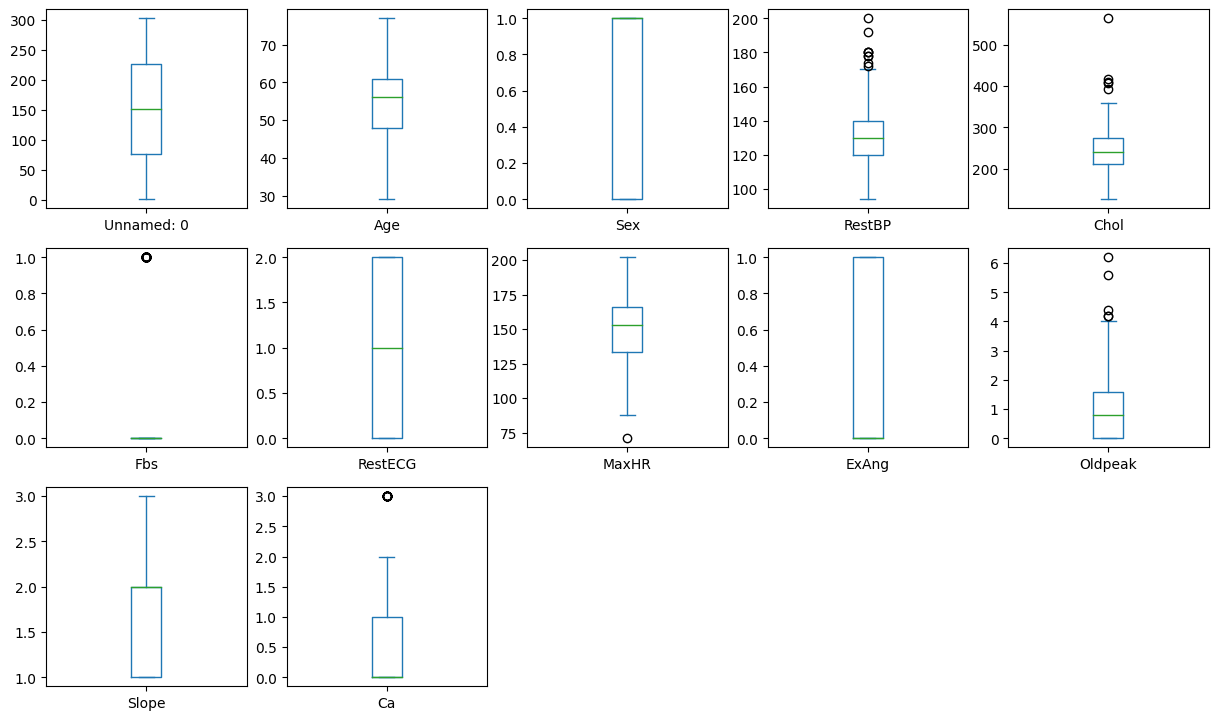

<Figure size 1500x800 with 0 Axes>

In [15]:
# histograma e boxplot
df.hist(bins=15, figsize=(15, 10), layout=(5, 5))
df.plot(kind='box', subplots=True, layout=(5, 5), sharex=False, sharey=False, figsize=(15, 15))

plt.figure(figsize=(15, 8))

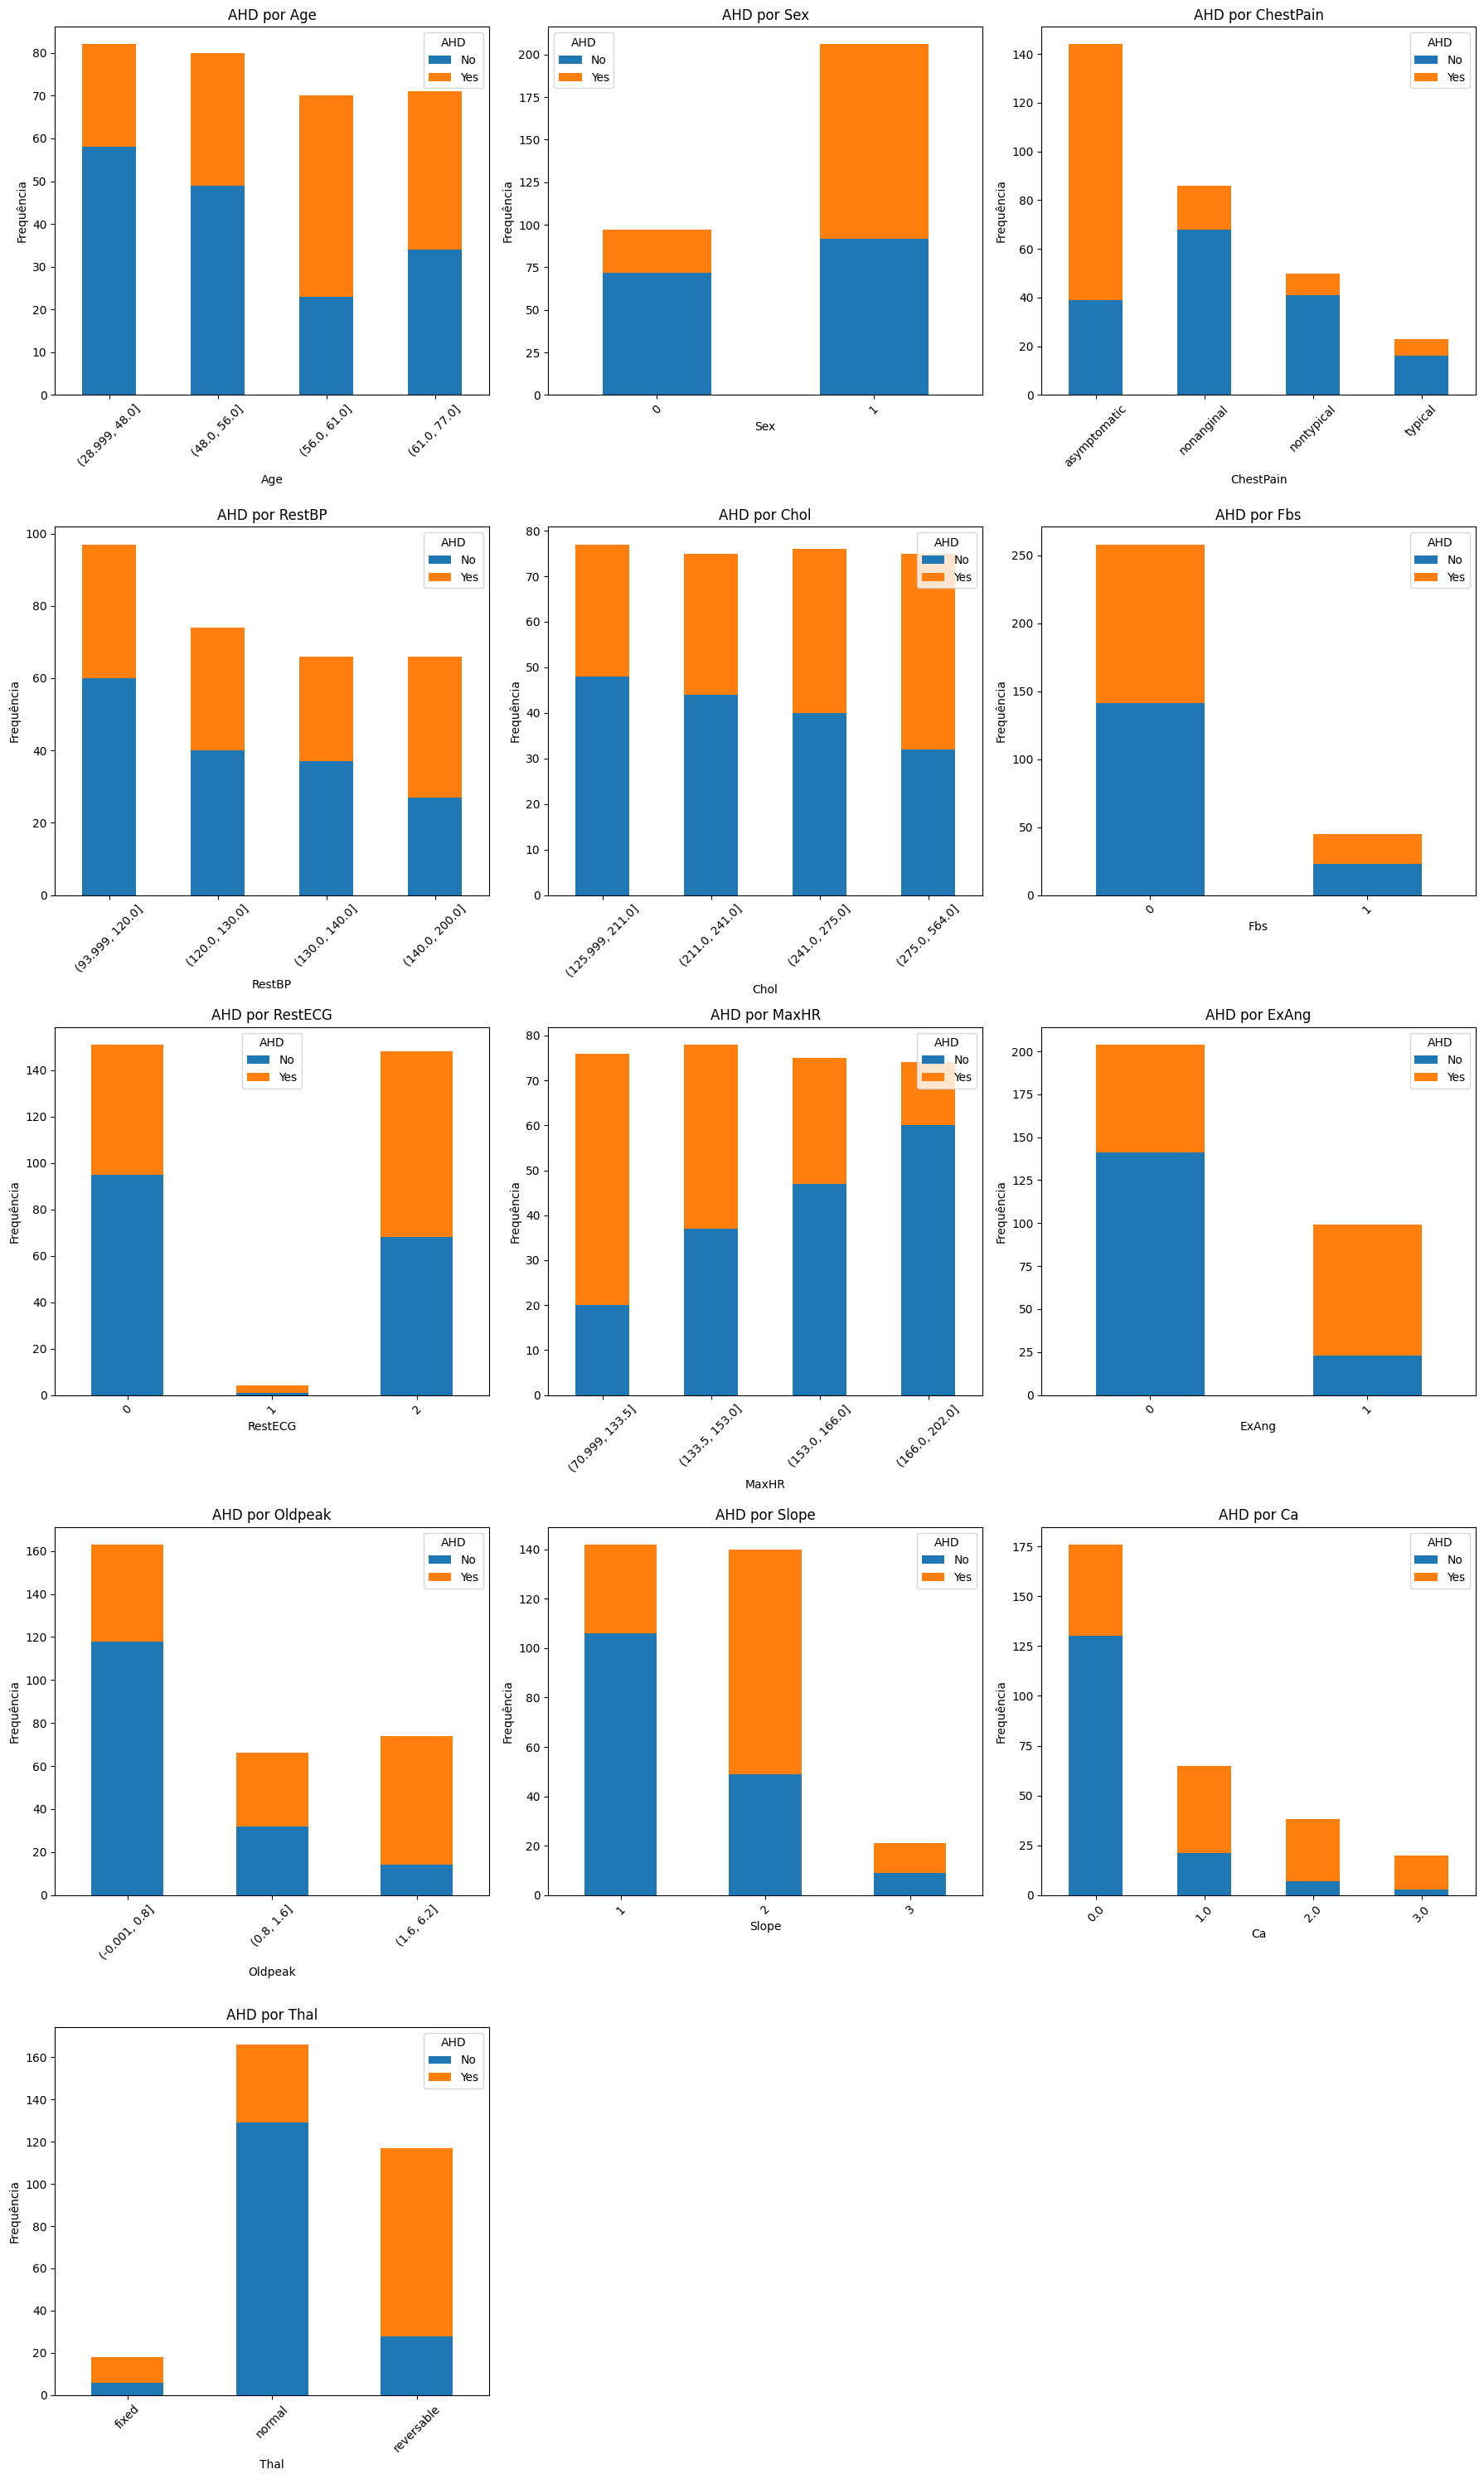

In [16]:
# subconjunto de colunas para a visualização
colunas_selecionadas = ['Age', 'Sex', 'ChestPain', 'RestBP', 'Chol', 'Fbs',
       'RestECG', 'MaxHR', 'ExAng', 'Oldpeak', 'Slope', 'Ca', 'Thal']

# layout da grade
n_colunas = 3
n_linhas = (len(colunas_selecionadas) + n_colunas - 1) // n_colunas

fig, axs = plt.subplots(n_linhas, n_colunas, figsize=(18, n_linhas * 6))

for index, column_name in enumerate(colunas_selecionadas):
    linha = index // n_colunas
    coluna = index % n_colunas

    # categorizar colunas numéricas por quartis
    if df[column_name].dtype in ['int64', 'float64'] and len(df[column_name].unique()) > 10:
        data_temp = df.copy()
        data_temp[column_name] = pd.qcut(data_temp[column_name], q=4, duplicates='drop')  # categorizar em quartis
    else:
        data_temp = df

    # agrupar por coluna e AHD
    trend = data_temp.groupby([column_name, 'AHD']).size().unstack()

    # plot do subplot
    trend.plot(kind='bar', stacked=True, ax=axs[linha, coluna])
    axs[linha, coluna].set_title(f'AHD por {column_name}')
    axs[linha, coluna].set_xlabel(column_name)
    axs[linha, coluna].set_ylabel('Frequência')
    axs[linha, coluna].legend(title='AHD')
    axs[linha, coluna].tick_params(axis='x', rotation=45)

for i in range(index + 1, n_linhas * n_colunas):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



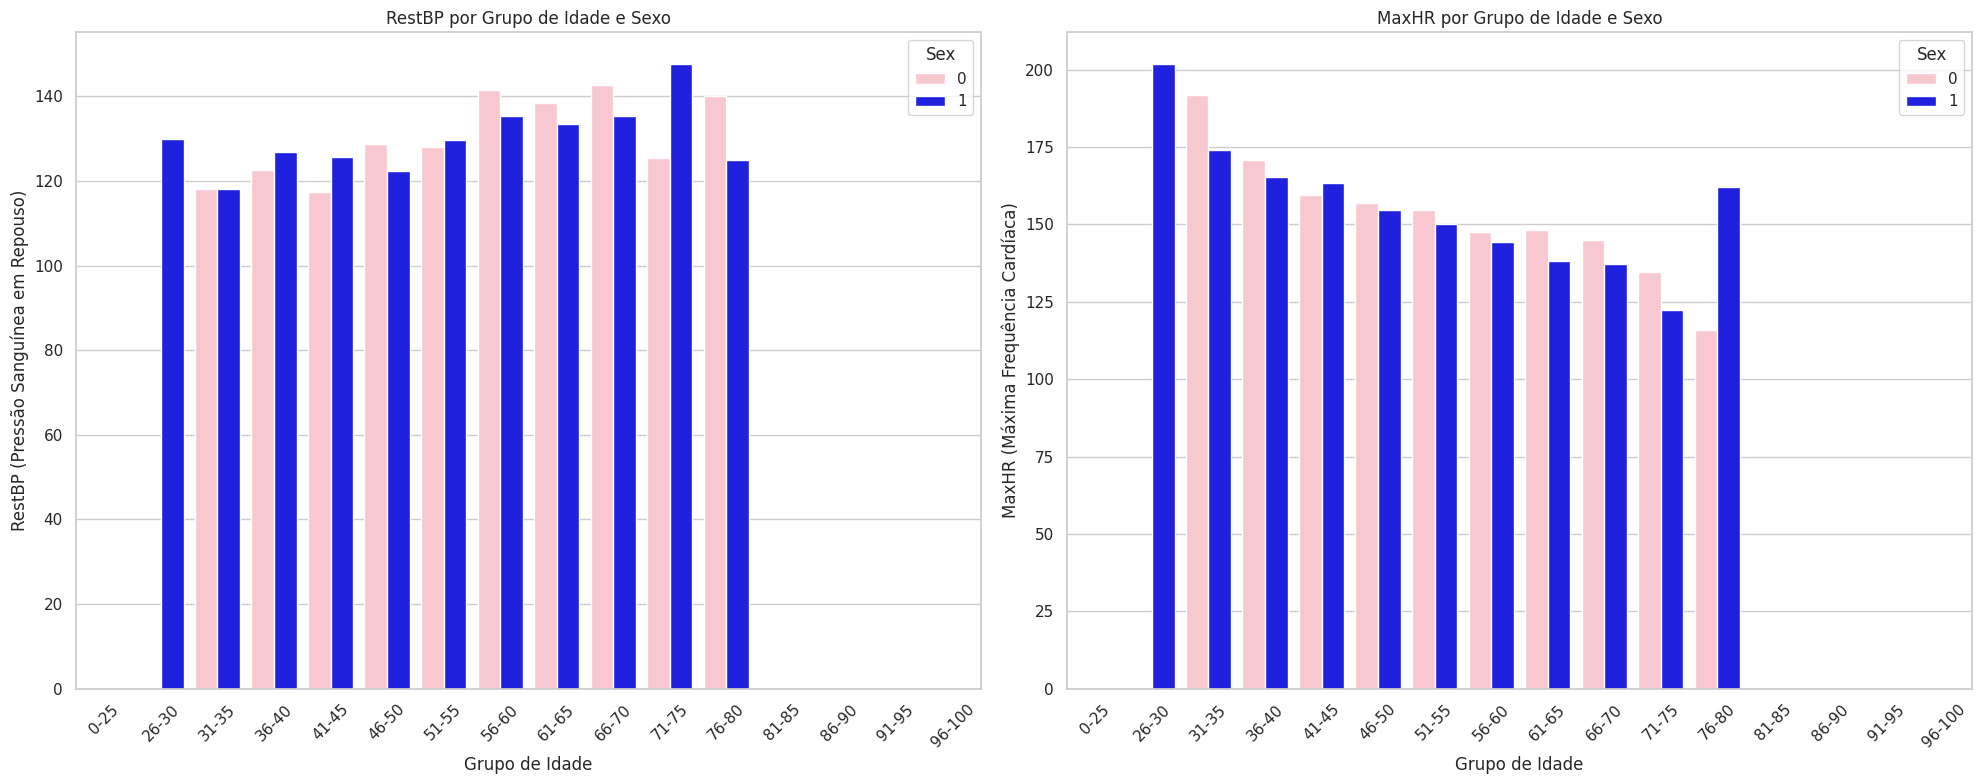

In [17]:
# relacao entre sexo e batimento cardiaco

# limites dos intervalos de idade
age_bins = [0, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
age_labels = ['0-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '66-70', '71-75', '76-80', '81-85', '86-90', '91-95', '96-100']
df['Age Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

sns.set(style="whitegrid")
plt.figure(figsize=(20, 8))

# Gráfico para 'RestBP' por Grupo de Idade e Sexo
plt.subplot(1, 2, 1)
sns.barplot(x='Age Group', y='RestBP', hue='Sex', data=df, palette={0: 'pink', 1: 'blue'}, ci=None)
plt.title('RestBP por Grupo de Idade e Sexo')
plt.xlabel('Grupo de Idade')
plt.ylabel('RestBP (Pressão Sanguínea em Repouso)')
plt.xticks(rotation=45)

# Gráfico para 'MaxHR' por Grupo de Idade e Sexo
plt.subplot(1, 2, 2)
sns.barplot(x='Age Group', y='MaxHR', hue='Sex', data=df, palette={0: 'pink', 1: 'blue'}, ci=None)
plt.title('MaxHR por Grupo de Idade e Sexo')
plt.xlabel('Grupo de Idade')
plt.ylabel('MaxHR (Máxima Frequência Cardíaca)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

>>> Os gráficos gerados acima fornecem informações sobre as distribuições de RestBP (Pressão Sanguínea em Repouso) e MaxHR (Máxima Frequência Cardíaca) por grupo de idade e sexo. `O objetivo era conseguir justificar qual sexo se trata os labels 0 e 1. A hipotese era`: homemns por conta do coracao ser geneticamente maior seus numeros seriam maiores que os da mulheres. Isso de fato pode ser visto em alguns intervalos nos graficos, mas nem sempre. No entanto, sem conhecimento específico ou dados contextuais adicionais, não é possível tirar conclusões definitivas sobre qual número representa qual sexo apenas com base nesses gráficos.

>>> Em muitos conjuntos de dados, o número 1 é frequentemente usado para representar o sexo masculino e o número 0 para o feminino, mas isso é uma convenção e não uma regra. Por falta de provas adotraremos a convenção.

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


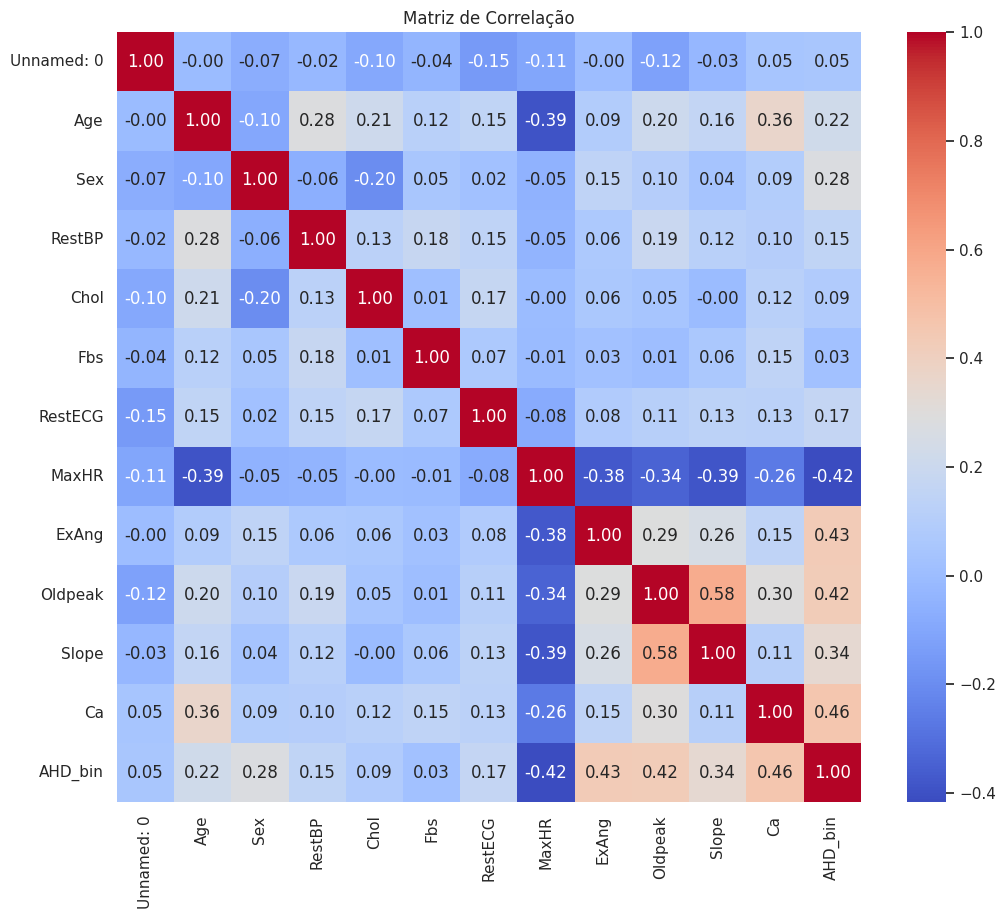

In [18]:
# binarizar a coluna AHD: 'No' será 0 e 'Yes' será 1
df['AHD_bin'] = df['AHD'].map({'No': 0, 'Yes': 1})

# matriz de correlação
correlacao = df.corr()

# máscara para a metade superior da matriz
mask = np.triu(np.ones_like(correlacao, dtype=bool))

# Plotar a matriz de correlação atualizada com a máscara aplicada
plt.figure(figsize=(12, 10))
sns.heatmap(correlacao, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlação')
plt.show()

>>> Da matriz ja podemos perceber um correlacao importante (diretamente e indiretamente) de algumas variaveis com a variavel alvo AHD_bin. Sendo elas:
* MaxHR (-0.42)
* ExAng (0.43)
* Oldpeak (0.42)
* Slope (0.34)
* Ca (0.46)

>>> Essas correlacoes podem servir como base de analise quando definirmos as features importances.

# Transformacao de Dados

Abordagem diferentes para os dados faltates, faremos de duas formas:
* 1 - preencher com os valores mais comuns do dataset
* 2 - apagar os registros com valores faltantes

## abordagem 1

In [19]:
# valor mais comum para cada uma das colunas
ca_comum = 0.0
thal_comum = "normal"

# preencher os dados faltantes
df_1 = df.copy()
df_1['Ca'].fillna(ca_comum, inplace=True)
df_1['Thal'].fillna(thal_comum, inplace=True)

In [20]:
# One-Hot Encoding nas colunas 'ChestPain' e 'Thal'
df_1 = pd.get_dummies(df_1, columns=['ChestPain', 'Thal'])
df_1.head(10)

Unnamed: 0  Age  Sex  RestBP  Chol  Fbs  RestECG  MaxHR  ExAng  Oldpeak  \
0           1   63    1     145   233    1        2    150      0      2.3   
1           2   67    1     160   286    0        2    108      1      1.5   
2           3   67    1     120   229    0        2    129      1      2.6   
3           4   37    1     130   250    0        0    187      0      3.5   
4           5   41    0     130   204    0        2    172      0      1.4   
5           6   56    1     120   236    0        0    178      0      0.8   
6           7   62    0     140   268    0        2    160      0      3.6   
7           8   57    0     120   354    0        0    163      1      0.6   
8           9   63    1     130   254    0        2    147      0      1.4   
9          10   53    1     140   203    1        2    155      1      3.1   

   ...  AHD  Age Group AHD_bin ChestPain_asymptomatic  ChestPain_nonanginal  \
0  ...   No      61-65       0                      0                     0   
1  ...  Yes      66-70       1                      1                     0   
2  ...  Yes      66-70       1                      1                     0   
3  ...   No      36-40       0                      0                     1   
4  ...   No      41-45       0                      0                     0   
5  ...   No      56-60       0                      0                     0   
6  ...  Yes      61-65       1                      1                     0   
7  ...   No      56-60       0                      1                     0   
8  ...  Yes      61-65       1                      1                     0   
9  ...  Yes      51-55       1                      1                     0   

   ChestPain_nontypical  ChestPain_typical  Thal_fixed  Thal_normal  \
0                     0                  1           1            0   
1                     0                  0           0            1   
2                     0                  0           0            0   
3                     0                  0           0            1   
4                     1                  0           0            1   
5                     1                  0           0            1   
6                     0                  0           0            1   
7                     0                  0           0            1   
8                     0                  0           0            0   
9                     0                  0           0            0   

   Thal_reversable  
0                0  
1                0  
2                1  
3                0  
4                0  
5                0  
6                0  
7                0  
8                1  
9                1  

[10 rows x 22 columns]

In [21]:
# padronização da IDADE com z-score
media_idade = df_1['Age'].mean()
desvio_padrao_idade = df_1['Age'].std()

df_1['Age_normalized'] = df_1['Age'].apply(lambda x: (x - media_idade) / desvio_padrao_idade)

In [22]:
# normalizar o restante dos dados com Min-Maxx
excluded_columns = ['Age', 'AHD', 'Age Group']

min_max_scaler = MinMaxScaler()
for column in df_1.columns:
    if column not in excluded_columns:  # Verifica se a coluna não está na lista de excluídas
        df_1[column] = min_max_scaler.fit_transform(df_1[[column]])

In [23]:
df_1 = df_1.drop(columns=["AHD","Unnamed: 0","Age",'Age Group'], axis = 1)

In [24]:
df_1.shape

(303, 19)

In [25]:
df_1.columns

Index(['Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR', 'ExAng', 'Oldpeak',
       'Slope', 'Ca', 'AHD_bin', 'ChestPain_asymptomatic',
       'ChestPain_nonanginal', 'ChestPain_nontypical', 'ChestPain_typical',
       'Thal_fixed', 'Thal_normal', 'Thal_reversable', 'Age_normalized'],
      dtype='object')

## abordagem 2

In [26]:
df_2 = df.copy()
df_2 = df_2.dropna()

In [27]:
nulos_por_coluna = df_2.isnull().sum()
nulos_por_coluna

Unnamed: 0    0
Age           0
Sex           0
ChestPain     0
RestBP        0
Chol          0
Fbs           0
RestECG       0
MaxHR         0
ExAng         0
Oldpeak       0
Slope         0
Ca            0
Thal          0
AHD           0
Age Group     0
AHD_bin       0
dtype: int64

## escolha a abordagem

In [28]:
# copia
data_prepared = df_1.copy()
#data_prepared = df_2.copy()
test_size = 0.2

# dividir o dataset
X = data_prepared.drop(['AHD_bin'], axis=1)
Y = data_prepared['AHD_bin']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)

print("Dimensões de X_train:", X_train.shape)
print("Dimensões de X_test:", X_test.shape)
print("Dimensões de y_train:", Y_train.shape)
print("Dimensões de y_test:", Y_test.shape)
print("\n")

Dimensões de X_train: (242, 18)
Dimensões de X_test: (61, 18)
Dimensões de y_train: (242,)
Dimensões de y_test: (61,)




>>>Ao lidar com conjuntos de dados, é comum encontrar valores ausentes em certos registros. Esses dados ausentes podem surgir de várias maneiras, desde erros de coleta até falhas nos sistemas de armazenamento de dados. A maneira como esses valores ausentes são tratados pode ter um impacto significativo nas análises subsequentes e nos modelos construídos a partir desses dados.

>>>Uma abordagem comum para lidar com dados ausentes é preenchê-los com a média dos valores existentes no conjunto de dados. Essa abordagem tem suas vantagens, como a preservação do tamanho do conjunto de dados e a manutenção da estrutura original dos dados. No entanto, ela também pode introduzir viés nos dados, especialmente se houver muitos valores ausentes ou se os dados não seguirem uma distribuição normal.

>>>Por outro lado, a remoção dos registros com dados ausentes é uma abordagem mais radical, mas muitas vezes eficaz. Essa abordagem evita a introdução de viés nos dados e simplifica a análise, eliminando os problemas associados aos dados ausentes. No entanto, ela também pode levar à perda de informações valiosas e à redução do tamanho do conjunto de dados, o que pode afetar a capacidade de generalização dos modelos construídos a partir desses dados.

>>>Em última análise, a escolha entre preencher ou remover dados ausentes depende do contexto específico do problema e das características dos dados. Ambas as abordagens têm suas vantagens e desvantagens, e é importante considerar cuidadosamente os prós e contras de cada uma antes de decidir qual estratégia adotar. O objetivo final é garantir a integridade e a confiabilidade dos dados utilizados nas análises e modelos subsequentes.

# **`EXERCICIO 1`**

# DECISION TREE

In [29]:
# listas para armazenar os erros
train_errors = []
test_errors = []
cv_means = []
cv_stds = []

error_rates = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

# intervalo de profundidades da árvore
max_depths = range(1, 26)

# treinar modelo com diferentes profundidades máximas
for depth in max_depths:
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)

    # calcular o erro no conjunto de treino
    dt_model.fit(X_train, Y_train)
    train_pred = dt_model.predict(X_train)
    train_errors.append(1 - accuracy_score(Y_train, train_pred))

    # o erro no conjunto de teste
    test_pred = dt_model.predict(X_test)
    test_errors.append(1 - accuracy_score(Y_test, test_pred))

    # validação cruzada
    cv_scores = cross_val_score(dt_model, X, Y, cv=5, scoring='accuracy')
    cv_means.append(1 - np.mean(cv_scores))
    cv_stds.append(np.std(cv_scores))


    # Medidas de desempenho
    accuracy = accuracy_score(Y_test, test_pred)
    precision = precision_score(Y_test, test_pred, average='weighted')
    recall = recall_score(Y_test, test_pred, average='weighted')
    f1 = f1_score(Y_test, test_pred, average='weighted')

    error_rates.append(error_rates)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

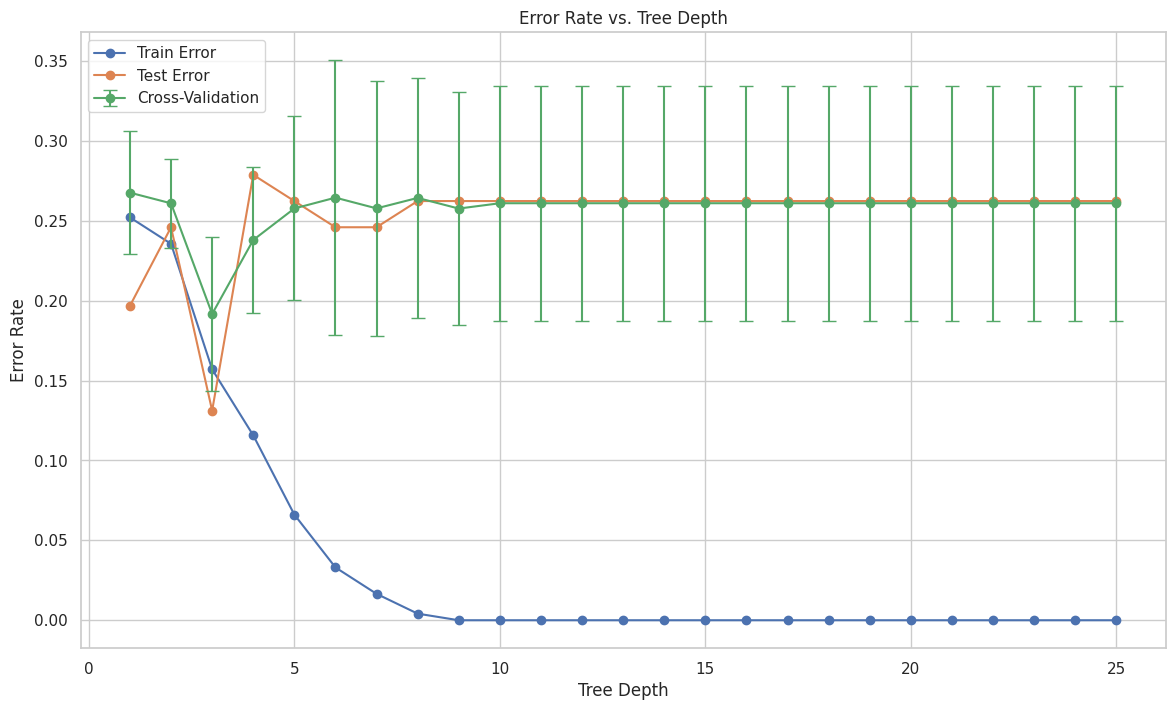

In [30]:
# plot
plt.figure(figsize=(14, 8))
plt.plot(max_depths, train_errors, label='Train Error', marker='o')
plt.plot(max_depths, test_errors, label='Test Error', marker='o')
plt.errorbar(max_depths, cv_means, yerr=cv_stds, label='Cross-Validation', marker='o', capsize=5)
#plt.plot(max_depths, cv_means, label='CV Mean Error', marker='o')
plt.title('Error Rate vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

>>> Inicialmente, à medida que a profundidade da árvore aumenta, a taxa de erro do conjunto de treino diminui drasticamente, o que indica que o modelo está se ajustando bem aos dados de treino. No entanto, o erro no conjunto de teste tende a `estabilizar após uma certa profundidade, sugerindo que aumentos adicionais na profundidade não resultam em melhorias significativas de generalização para novos dados`. Isso pode indicar que o modelo começa a sofrer de `overfitting`, onde se torna muito especializado nos dados de treino e perde a capacidade de generalizar.

>>> Por outro lado, a taxa de erro de validação cruzada, que fornece uma estimativa robusta do desempenho do modelo em dados não vistos, mostra uma variação maior em relação às taxas de erro de treino e teste. O uso de barras de erro (desvio padrão dos resultados da validação cruzada) destaca a incerteza na estimativa de desempenho do modelo.` Observa-se que a taxa de erro de validação cruzada estabiliza em uma profundidade menor do que a taxa de erro de treino`, ressaltando a importância de considerar a complexidade do modelo e evitar overfitting para melhorar a capacidade de generalização do modelo.

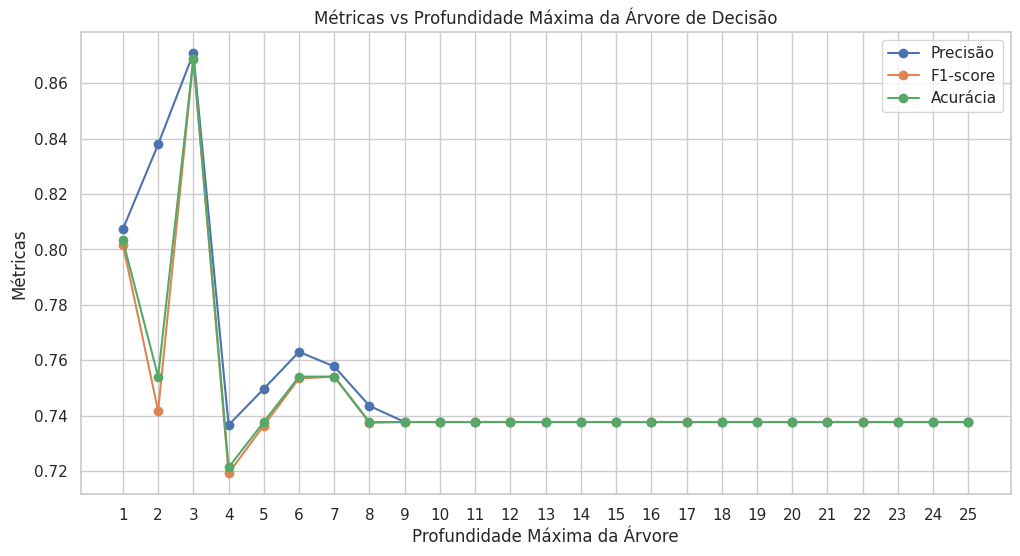

In [31]:
# Plotando o gráfico de métricas vs profundidade máxima da árvore de decisão
plt.figure(figsize=(12, 6))
plt.plot(max_depths, precisions, marker='o', linestyle='-', label='Precisão')
plt.plot(max_depths, f1_scores, marker='o', linestyle='-', label='F1-score')
plt.plot(max_depths, accuracies, marker='o', linestyle='-', label='Acurácia')
plt.title('Métricas vs Profundidade Máxima da Árvore de Decisão')
plt.xlabel('Profundidade Máxima da Árvore')
plt.ylabel('Métricas')
plt.xticks(max_depths)
plt.legend()
plt.grid(True)
plt.show()

>>>Aqui decidimos simplificar o grafico para melhor entendimento, temos a taxa de erro do treinamento e abaixo as algumas outras medidas de desempenho no qual podemos tomar indicios:

>>>Acurácia: fornece uma medida geral de quão bem o modelo está performando.


>>>Precisão: indica a proporção de resultados relevantes entre os resultados sugeridos. É útil quando os falsos positivos são custosos.


>>>F1-score: combina precisão e recall, oferecendo uma visão equilibrada do desempenho do modelo, especialmente quando as classes estão desbalanceadas ou quando os tipos de erros têm custos diferentes.

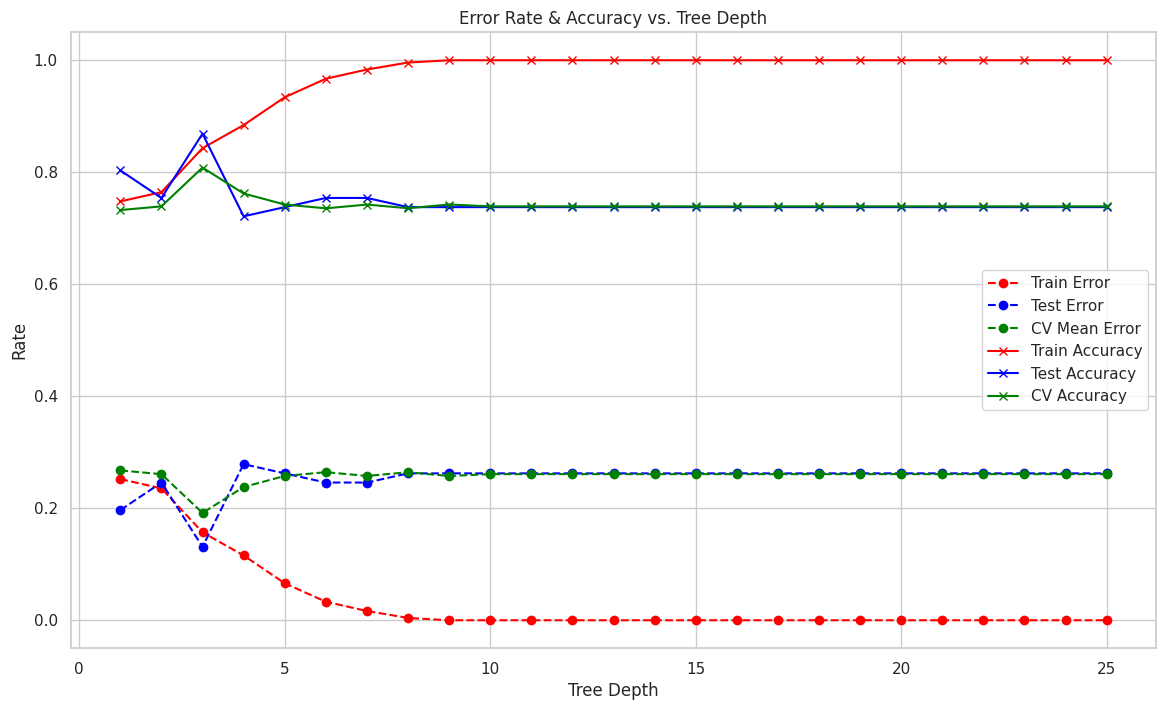

In [32]:
# listas para armazenar as acurácias
train_accuracies = []
test_accuracies = []
cv_mean_accuracies = []

# mudando erros calculados em acurácias
train_accuracies = [1 - error for error in train_errors]
test_accuracies = [1 - error for error in test_errors]
cv_mean_accuracies = [1 - error for error in cv_means]

# plota
plt.figure(figsize=(14, 8))

# erros
plt.plot(max_depths, train_errors, label='Train Error', marker='o', linestyle='--', color='red')
plt.plot(max_depths, test_errors, label='Test Error', marker='o', linestyle='--', color='blue')
plt.plot(max_depths, cv_means, label='CV Mean Error', marker='o', linestyle='--', color='green')

# acuracias
plt.plot(max_depths, train_accuracies, label='Train Accuracy', marker='x', color='red')
plt.plot(max_depths, test_accuracies, label='Test Accuracy', marker='x', color='blue')
plt.plot(max_depths, cv_mean_accuracies, label='CV Accuracy', marker='x', color='green')

plt.title('Error Rate & Accuracy vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.show()

>>> Esse grafico apenas traz uma analise contraria ao erro, afinal acuracia é mais usual de se analisar o modelo.

In [33]:
# definir a profundidade para analise
max_depth = 3

# treinar o modelo de DT
dt_model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
dt_model.fit(X_train, Y_train)
Y_pred = dt_model.predict(X_test)

# avaliar o desempenho
accuracy = accuracy_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)
classification_rep = classification_report(Y_test, Y_pred)

print(accuracy)
print(roc_auc)
print("\n")
print(classification_rep)

0.8688524590163934
0.8701508620689655


              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87        29
         1.0       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



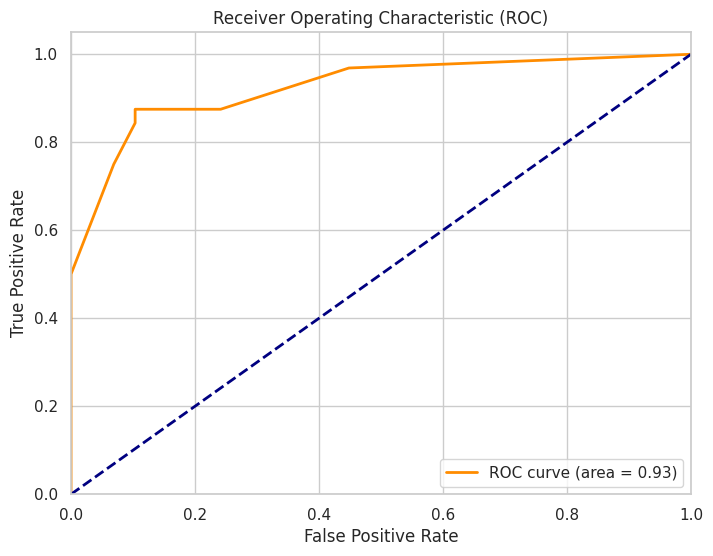

In [34]:
#plotar a curva ROC
Y_pred_proba = dt_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# área sob a curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

>>> O AUC de 0,93, mostrado no gráfico, é um excelente resultado, indicando que o modelo tem um alto grau de discriminação. Isso significa que o modelo tem uma alta probabilidade de classificar corretamente um paciente aleatório com a doença como positivo e um paciente sem a doença como negativo.

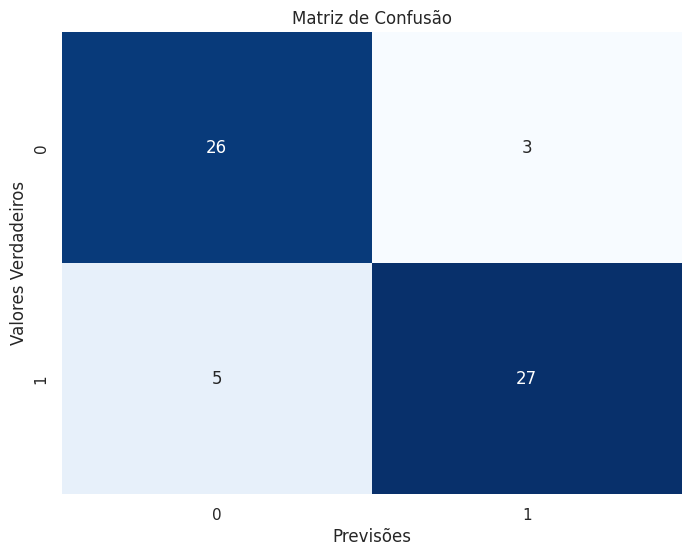

In [35]:
# plot da matriz de confusao
cm = confusion_matrix(Y_test, Y_pred)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.xlabel('Previsões')
plt.ylabel('Valores Verdadeiros')
plt.show()

>>> A matriz de confusão nos ajuda a avaliar o modelo, com ela é possível analisar as taxas de erro do modelo. Com uma acc de 80% já espera-se que o modelo erre um pouco (diagonal segundaria) e acerte mais (diagonal principal). Nesse caso o modelo performou bem.

## Cenarios DT

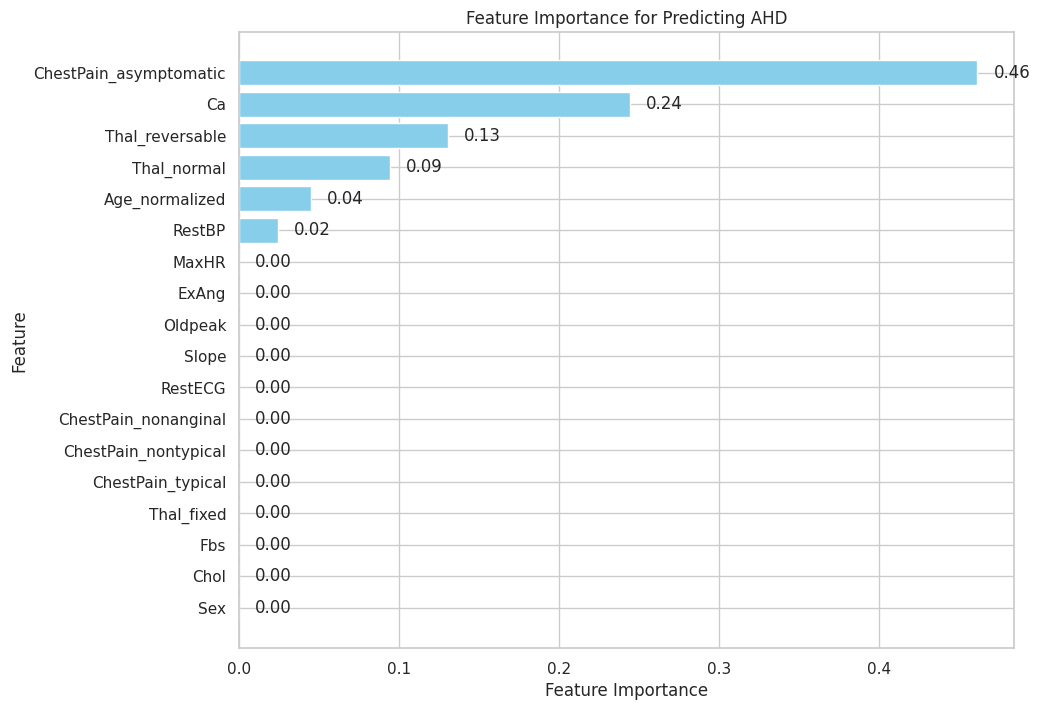

In [36]:
# importância das características do modelo treinado
feature_importances = dt_model.feature_importances_

# importância com os nomes das colunas
features = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot
plt.figure(figsize=(10, 8))
bars = plt.barh(feature_importance_sorted['Feature'], feature_importance_sorted['Importance'], color='skyblue')

# add valores no gráfico
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01,  #
             bar.get_y() + bar.get_height() / 2,
             '{:.2f}'.format(width),
             va='center')

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Predicting AHD')
plt.gca().invert_yaxis()
plt.show()

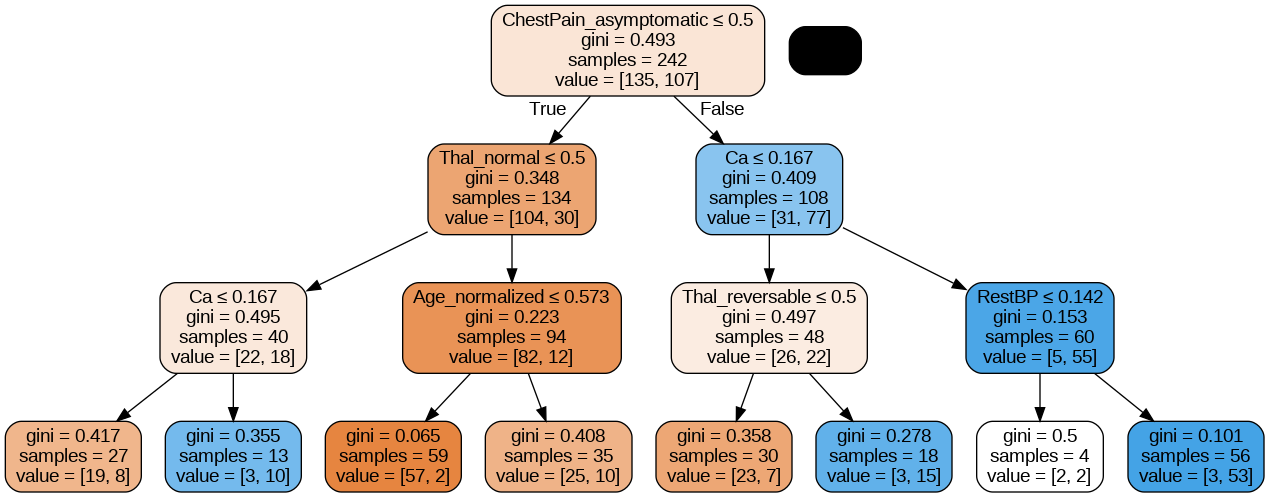

In [37]:
dot_data = StringIO()
export_graphviz(dt_model, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

>>>O gráfico da árvore de decisão é uma representação visual da estrutura de uma árvore de decisão, que é um modelo de aprendizado de máquina usado para classificação e regressão. A árvore de decisão é construída a partir de um conjunto de dados de treinamento, onde cada nó da árvore representa uma característica do conjunto de dados, e cada ramificação representa uma decisão baseada nessa característica. Os nós folha representam as classes ou valores previstos pelo modelo.

Classe real: 0.0, Classe predita: 0.0, Para a Sample index: 179


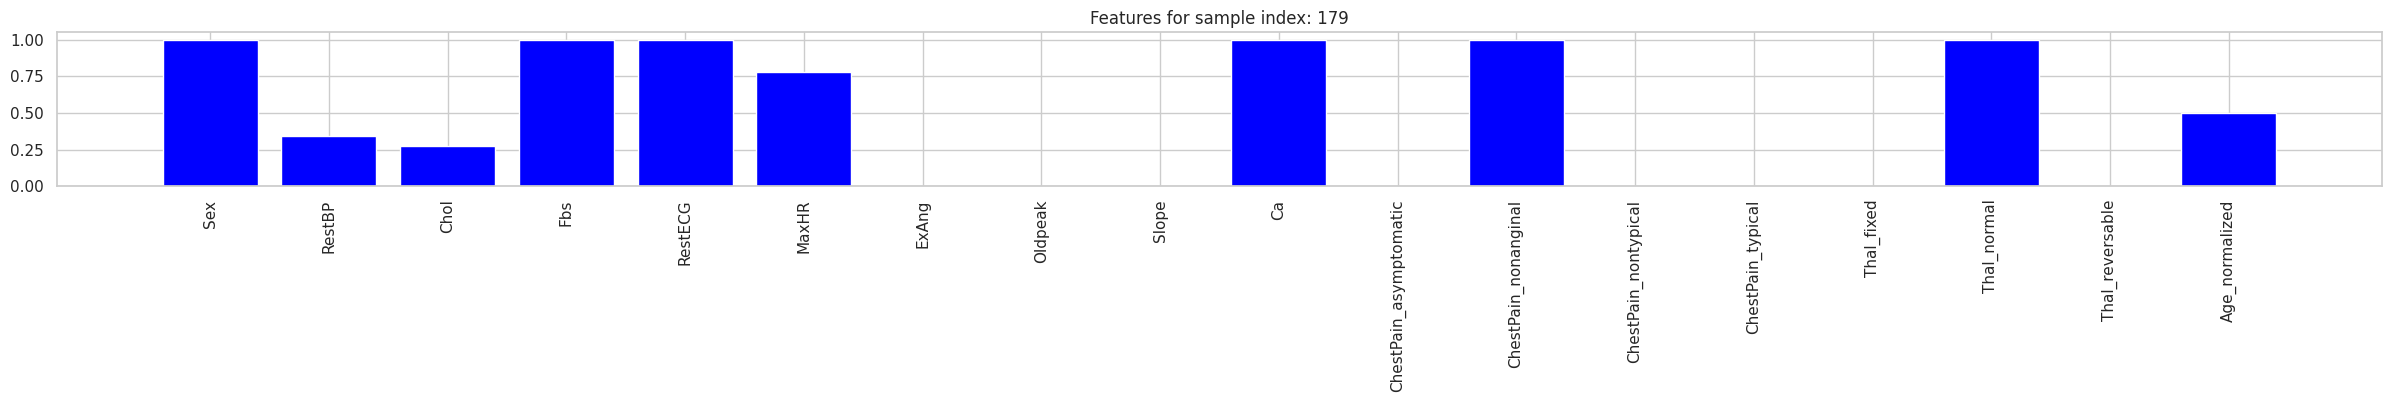

Classe real: 0.0, Classe predita: 0.0, Para a Sample index: 5


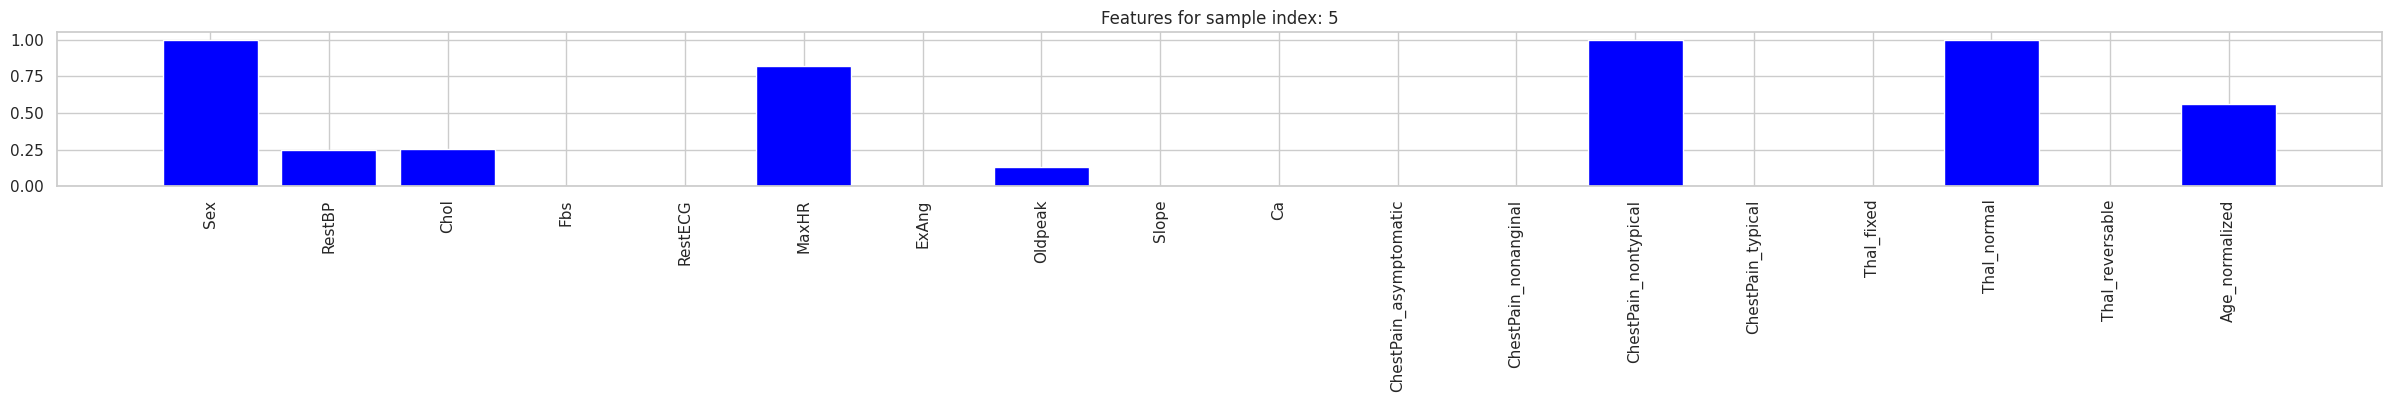

Classe real: 1.0, Classe predita: 1.0, Para a Sample index: 228


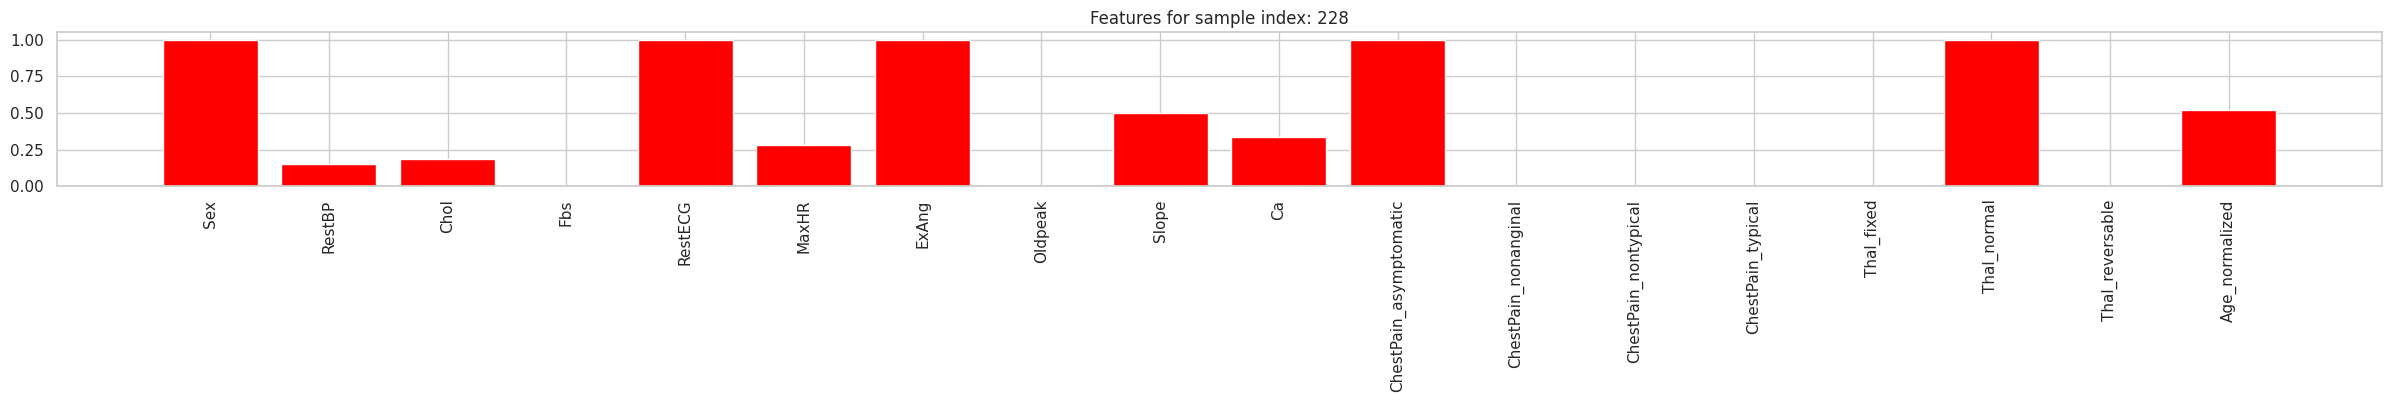

Classe real: 1.0, Classe predita: 1.0, Para a Sample index: 111


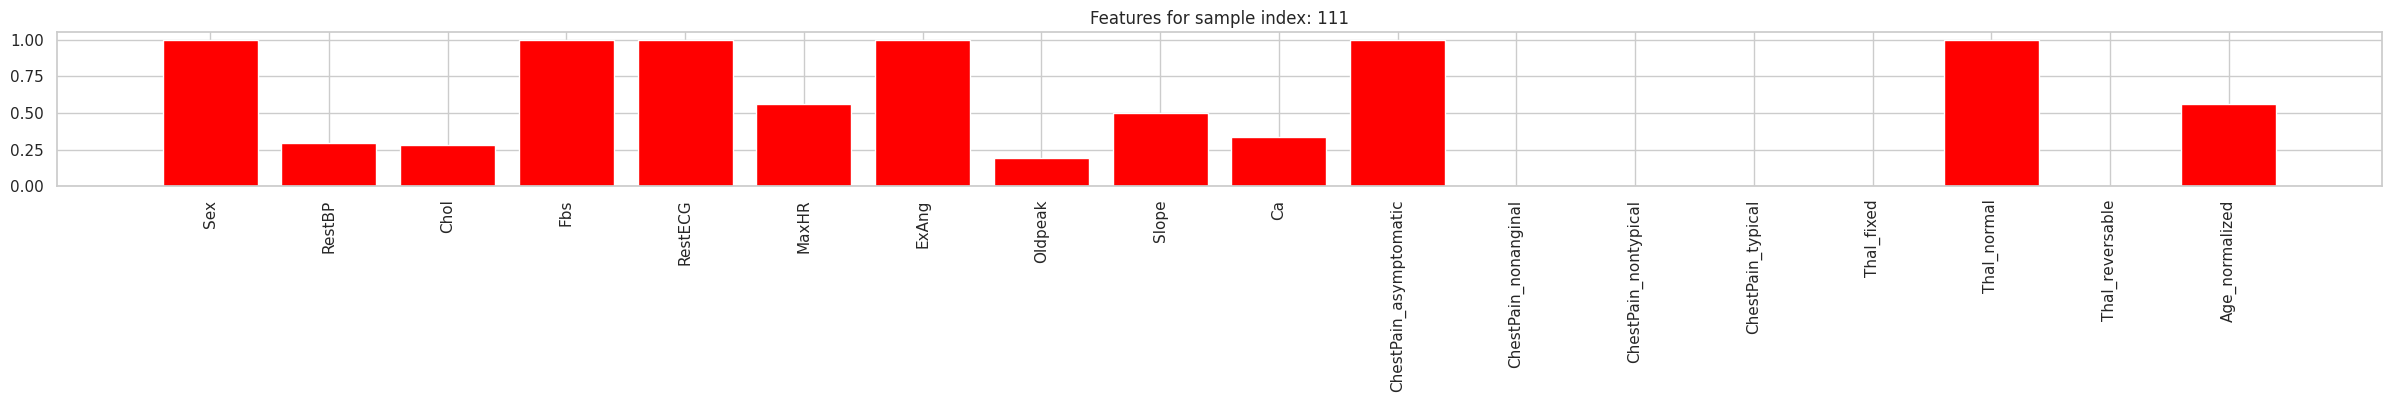

In [38]:
# listas para armazenar índices
indices_acertos_0 = []
indices_acertos_1 = []

# conjunto de teste e as previsões
for idx, (real, pred) in enumerate(zip(Y_test, Y_pred)):
    if real == pred:  # se a previsão corresponde ao label real
        if real == 0 and len(indices_acertos_0) < 2:
            indices_acertos_0.append(idx)
        elif real == 1 and len(indices_acertos_1) < 2:
            indices_acertos_1.append(idx)


indices_selecionados = indices_acertos_0 + indices_acertos_1
colunas = X_test.columns

for sample_idx in indices_selecionados:
    # encontrar o índice real no X_test para corresponder ao Y_pred
    real_idx = Y_test.index[sample_idx]

    instancia = X_test.loc[real_idx].tolist()
    label = Y_test.loc[real_idx]
    pred = Y_pred[sample_idx]

    print(f'Classe real: {label}, Classe predita: {pred}, Para a Sample index: {real_idx}')

    plt.figure(figsize=(30, 2))
    color = 'blue' if label == 0 else 'red'
    plt.bar(colunas, instancia, color=color)
    plt.xticks(rotation=90)
    plt.title(f'Features for sample index: {real_idx}')
    plt.show()

>>> Os graficos acima trazem apenas uma visualizacao de cada registro, mostrando qual os valores de cada varaivel para um label 0 e 1 (`dois de cada). Os indices podem ser ddefinidos aleatorios ou entao escolhidos. A intencao desse grafico eh vizualizar a similariedade entre registros diferentes com a  mesma label`. Com isso procuramos encontrar possiveis erros de classificacao.

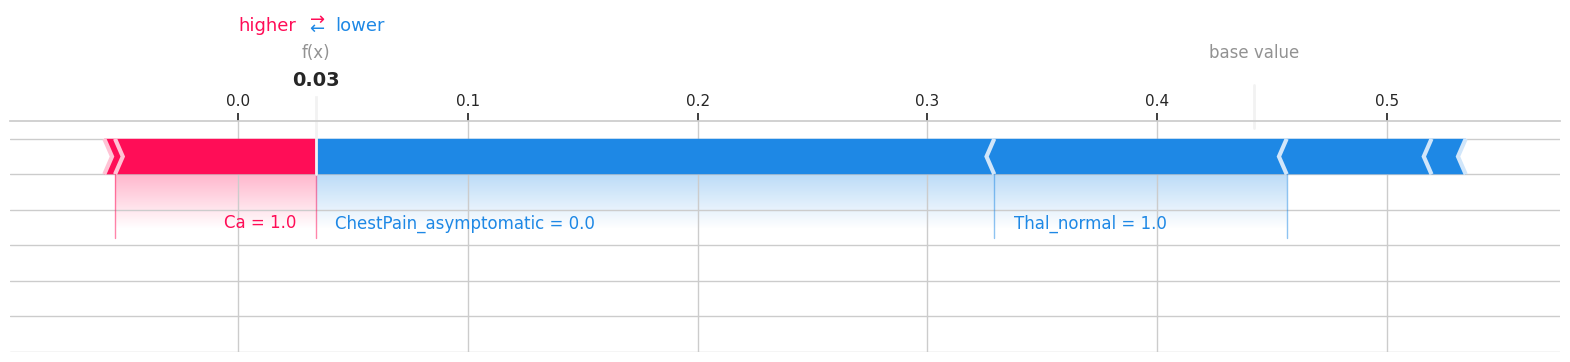

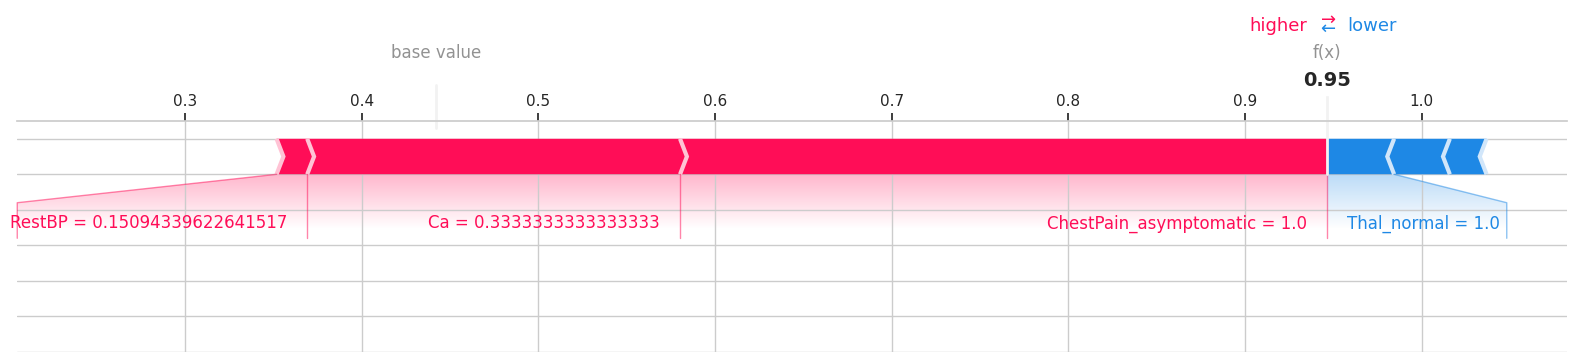

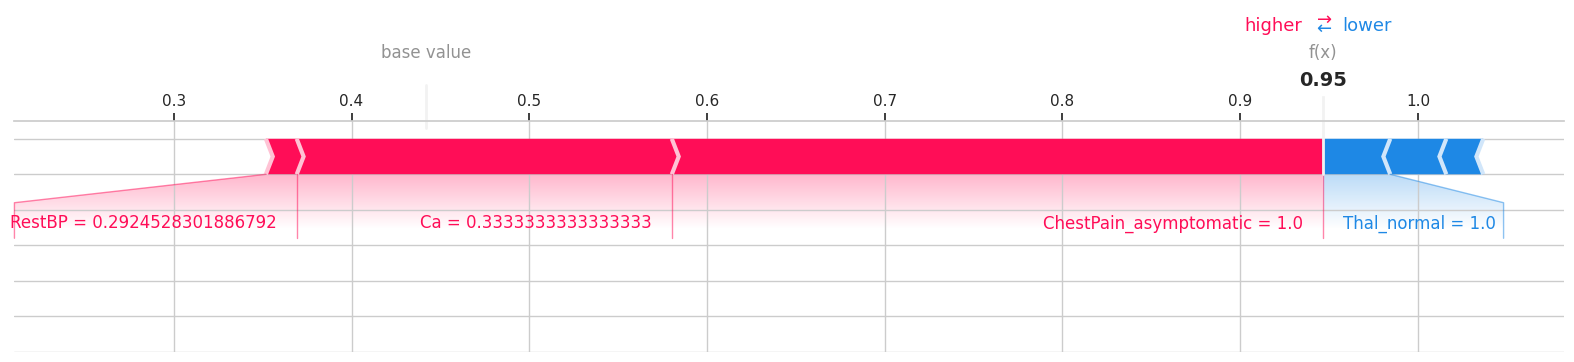

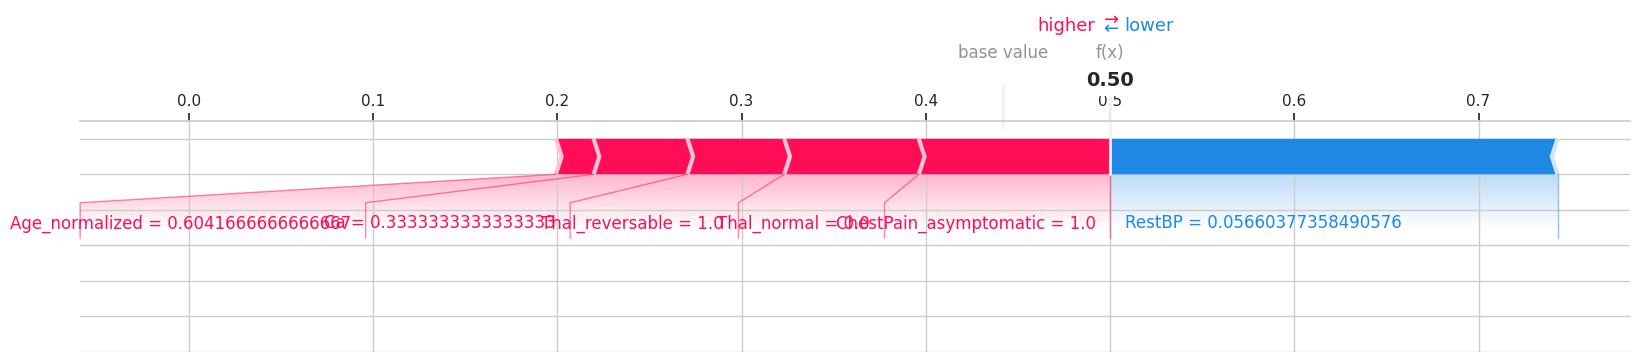

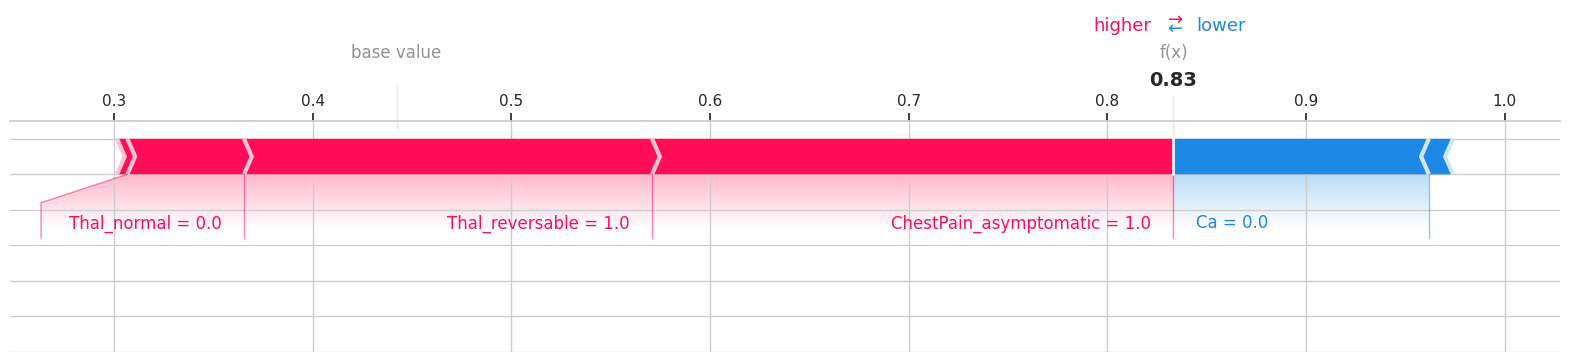

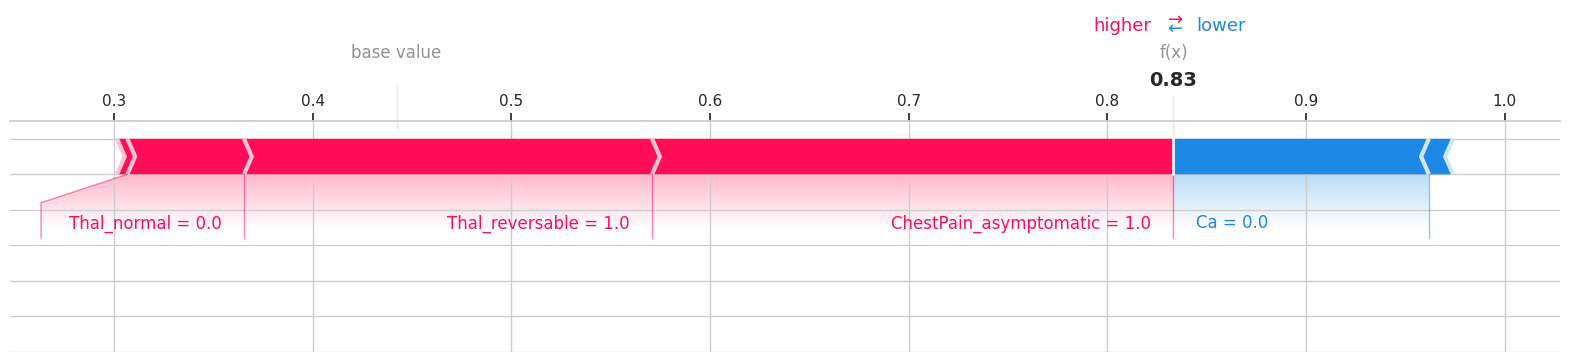

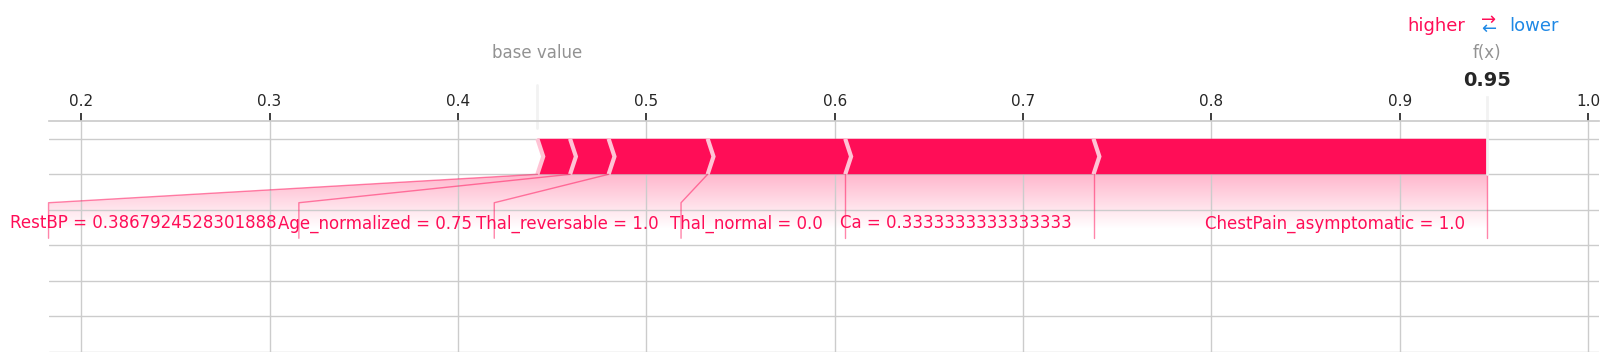

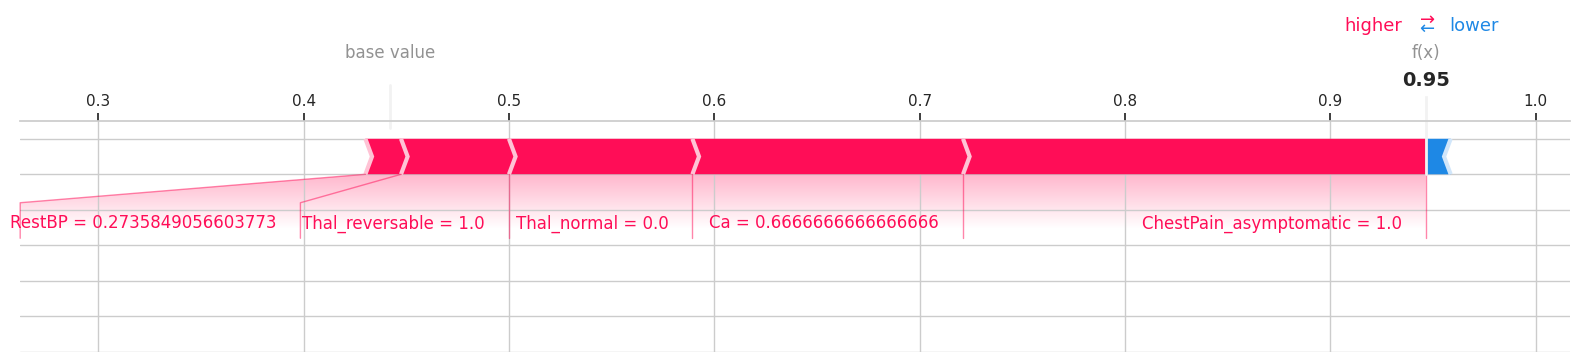

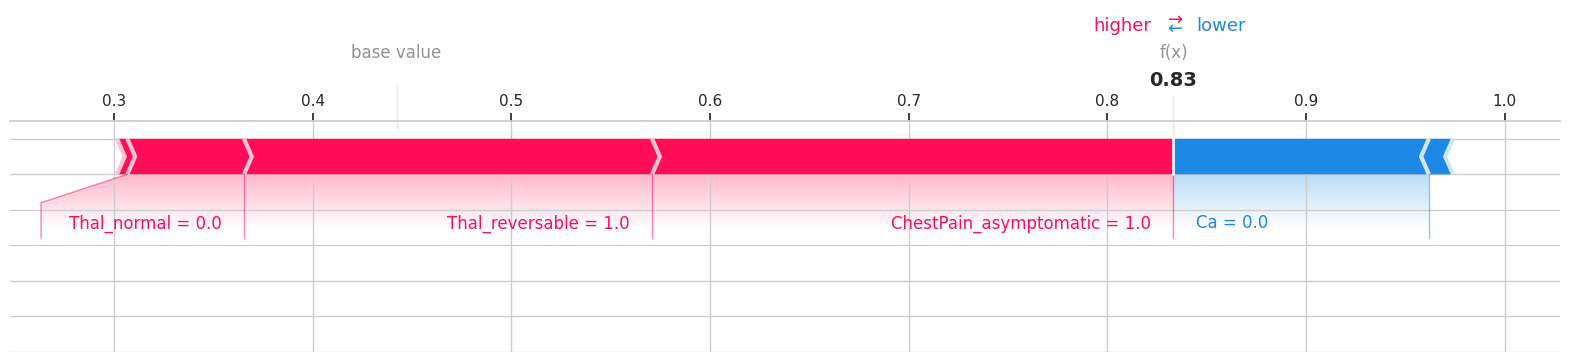

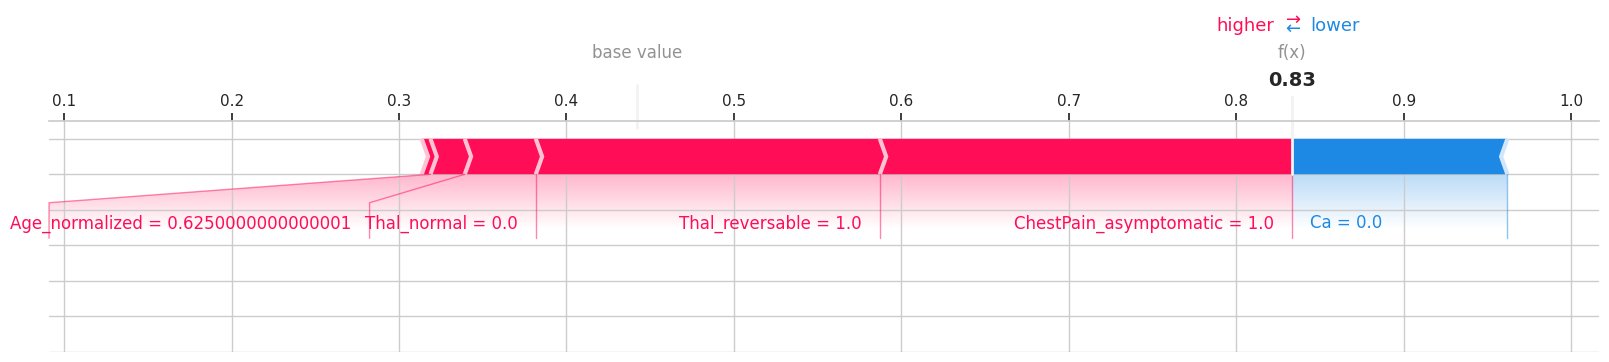

In [39]:
explainer = shap.TreeExplainer(dt_model)

# Calcular SHAP
shap_values = explainer.shap_values(X_test)

index = 2 # indice para escolher
shap.initjs()
#shap.force_plot(explainer.expected_value[1], shap_values[1][index], X_test.iloc[index])
for i in range(10):
    shap.force_plot(
        explainer.expected_value[1], shap_values[1][i],
        X_test.iloc[i], show=False, matplotlib=True
    )
    plt.show()

>>> Diferentemente dos graficos acima o gráfico de força SHAP, que é uma visualização que mostra a `contribuição de cada característica (feature) para a previsão de um modelo` de árvore de decisão para uma instância específica. A força de cada efeito é representada por barras horizontais, que podem estender-se para a esquerda ou para a direita do valor base. (`analogia com cabo de guerra`).

>>> Com isso torna mais facil saber para registros especificos o que foi que influenciou na sua classificacao.

**`Resposta da 1.2`** - Em nossa análise, identificamos que a característica "chespain" foi classificada como a mais relevante pelo nosso modelo de árvore de decisão. Pacientes que exibem um valor acima de 0.5 nessa característica demonstram uma alta probabilidade de não receberem um diagnóstico. Além disso, observamos que valores de "thal" acima de 0.5 e "CA" acima de 0.167 também indicam uma considerável probabilidade de não diagnóstico.

chestpain: indica o tipo de dor no peito do paciente, sendo um forte preditor da presença ou ausência da doença cardíaca.


thal: indica o resultado do teste de estresse cardíaco, sendo um indicador da função cardíaca do paciente.


CA: indica o número de vasos sanguíneos principais coloridos por fluoroscopia, sendo um indicador da gravidade da doença cardíaca.

Além disso, também analisamos minuciosamente cada característica que influencia o viés de decisão. As características que mais impactam na classificação positiva do diagnóstico são:

* Chest pain (dor no peito): Ausente (0,0)
* Thal_normal: 1
Portanto, se o paciente não apresenta dores no peito e possui uma condição cardíaca normal, há fortes indícios de que o diagnóstico não será positivo.

Já as características que mais influenciam no diagnóstico do paciente são:

* Chest pain_asymptomatic (dor no peito): Presente (1)
* CA: 0.33 ou mais
* Thal_normal: 0
* Thal_reversable: 1

Essa análise sugere que a idade normalizada, a presença de dor no peito, o valor de CA (que sao quantidade de vazos) e resultado do exame Thal são os principais fatores a serem considerados no diagnóstico do paciente.

`**CASOS NEGATIVOS**`

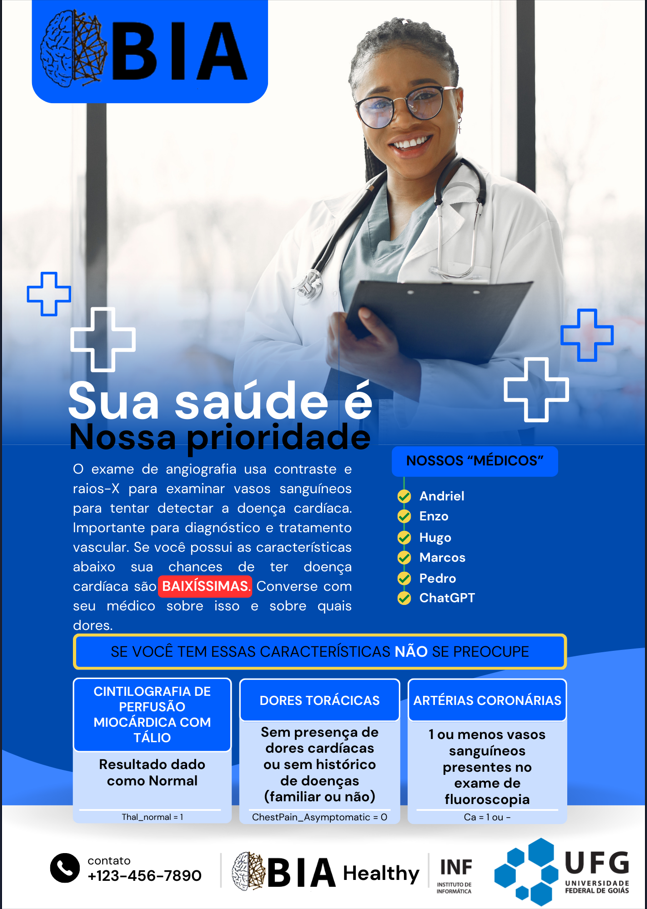

**`CASOS POSITIVOS`**

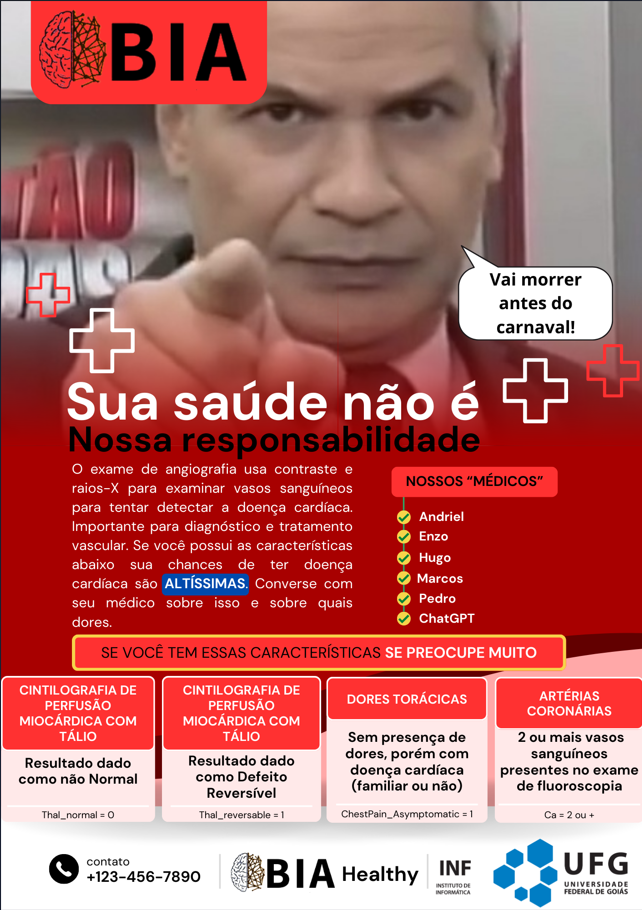

# **`EXERCICIO 2`**

# RANDOM FOREST

In [40]:
# lista para armazenar os erros de treino, teste e validação cruzada
train_errors = []
test_errors = []
cv_errors = []
cv_stds = []

error_rates = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
# profundidades máximas a serem testadas
max_depths = range(1, 31)

# treinar o modelo com diferentes profundidades máximas e calcular os erros
for max_depth in max_depths:
    rf_model = RandomForestClassifier(max_depth=max_depth, random_state=42)
    rf_model.fit(X_train, Y_train)

    # erro de treino
    Y_train_pred = rf_model.predict(X_train)
    train_errors.append(1 - accuracy_score(Y_train, Y_train_pred))

    # erro de teste
    Y_test_pred = rf_model.predict(X_test)
    test_errors.append(1 - accuracy_score(Y_test, Y_test_pred))

    # erro de validação cruzada
    cv_scores = cross_val_score(rf_model, X, Y, cv=5, scoring='accuracy')
    cv_errors.append(1 - np.mean(cv_scores))
    cv_stds.append(np.std(cv_scores))

    # Medidas de desempenho
    accuracy = accuracy_score(Y_test, Y_test_pred)
    precision = precision_score(Y_test, Y_test_pred, average='weighted')
    recall = recall_score(Y_test, Y_test_pred, average='weighted')
    f1 = f1_score(Y_test, Y_test_pred, average='weighted')

    error_rates.append(error_rates)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

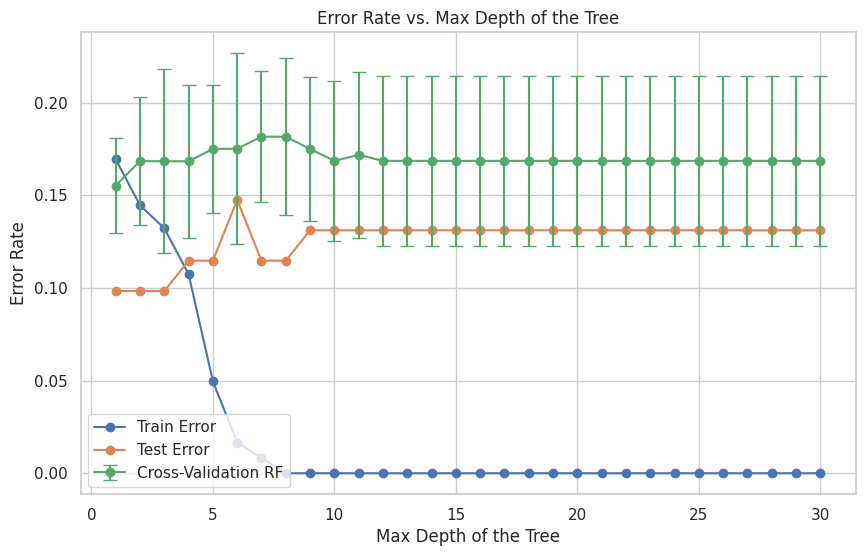

In [41]:
# plot
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_errors, label='Train Error', marker='o')
plt.plot(max_depths, test_errors, label='Test Error', marker='o')
plt.errorbar(max_depths, cv_errors, yerr=cv_stds, label='Cross-Validation RF', marker='o', capsize=5)
#plt.plot(max_depths, cv_errors, label='CV Error', marker='o')
plt.xlabel('Max Depth of the Tree')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Max Depth of the Tree')
plt.legend()
plt.grid(True)
plt.show()

>>> Diferentemente do grafico da Decision Tree aqui vemos que o valores de erro para a Random Forest se estabilizam logo no começo sendo seu ponto de minimo. A validacao cruzada demora um pouco mais a estabilizar caractrizando o overfitting por volta da profundidade de 10-11.

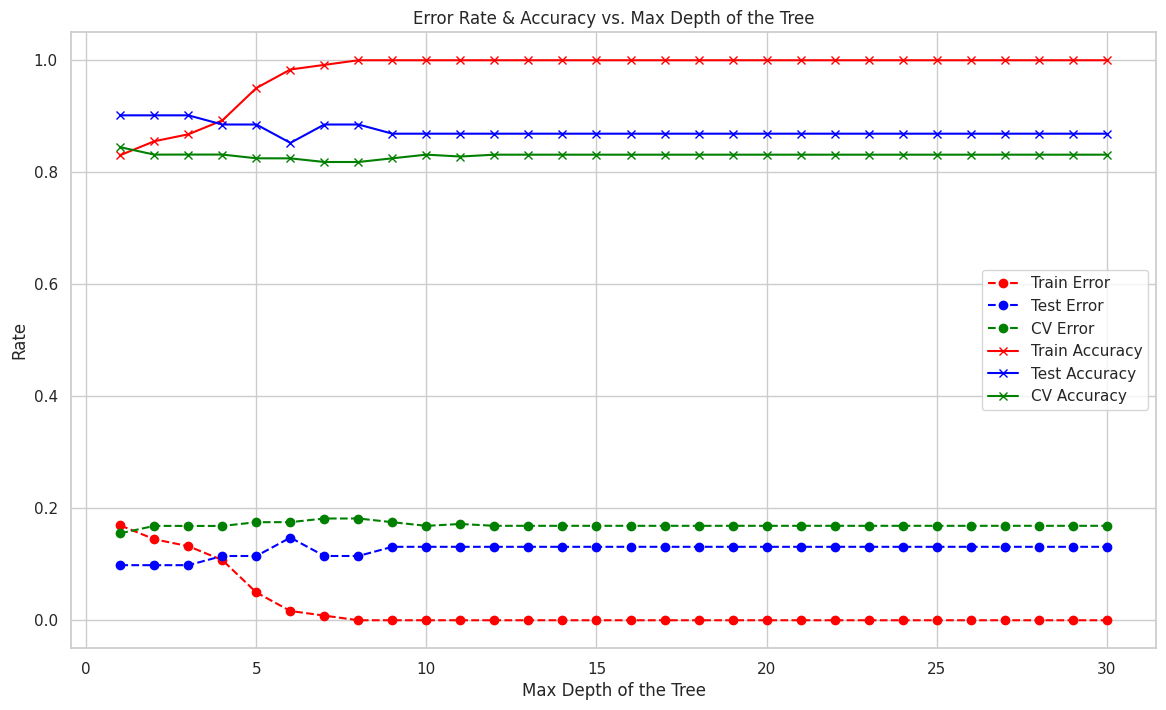

In [42]:
# convertendo erros em acurácias
train_accuracies = [1 - error for error in train_errors]
test_accuracies = [1 - error for error in test_errors]
cv_accuracies = [1 - error for error in cv_errors]

plt.figure(figsize=(14, 8))

# erros
plt.plot(max_depths, train_errors, label='Train Error', marker='o', linestyle='--', color='red')
plt.plot(max_depths, test_errors, label='Test Error', marker='o', linestyle='--', color='blue')
plt.plot(max_depths, cv_errors, label='CV Error', marker='o', linestyle='--', color='green')

# acuracias
plt.plot(max_depths, train_accuracies, label='Train Accuracy', marker='x', color='red')
plt.plot(max_depths, test_accuracies, label='Test Accuracy', marker='x', color='blue')
plt.plot(max_depths, cv_accuracies, label='CV Accuracy', marker='x', color='green')

plt.xlabel('Max Depth of the Tree')
plt.ylabel('Rate')
plt.title('Error Rate & Accuracy vs. Max Depth of the Tree')
plt.legend()
plt.grid(True)
plt.show()

>>> Esse grafico apenas traz uma analise contraria ao erro, afinal acuracia é mais usual de se analisar o modelo.

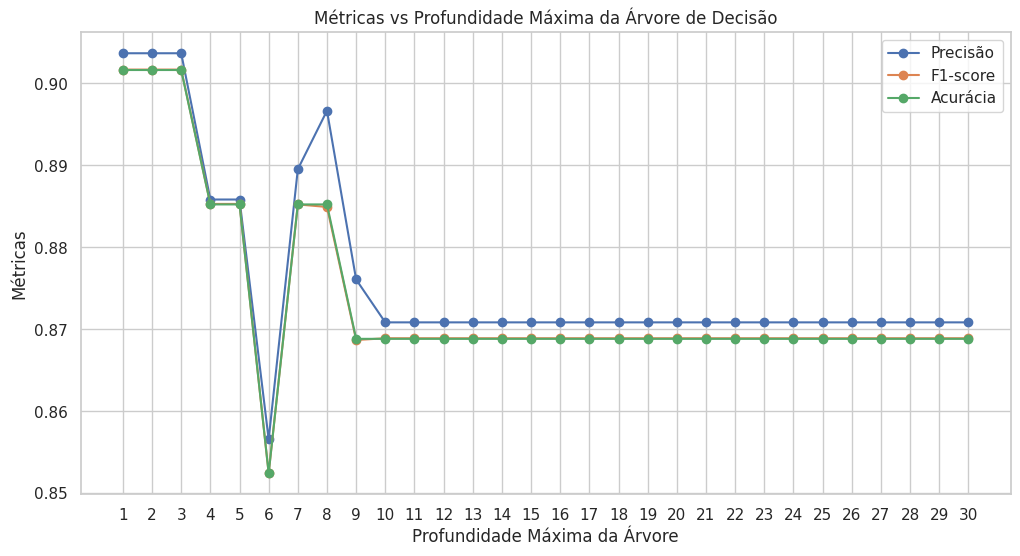

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(max_depths, precisions, marker='o', linestyle='-', label='Precisão')
plt.plot(max_depths, f1_scores, marker='o', linestyle='-', label='F1-score')
plt.plot(max_depths, accuracies, marker='o', linestyle='-', label='Acurácia')
plt.title('Métricas vs Profundidade Máxima da Árvore de Decisão')
plt.xlabel('Profundidade Máxima da Árvore')
plt.ylabel('Métricas')
plt.xticks(max_depths)
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# escolha da profundidade
max_depth=1

# Random Forest
rf_model = RandomForestClassifier(max_depth=max_depth, random_state=42)
rf_model.fit(X_train, Y_train)
Y_pred = rf_model.predict(X_test)

# avaliar o desempenho do modelo
accuracy = accuracy_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)
classification_rep = classification_report(Y_test, Y_pred)

print("Accuracy:", accuracy)
print("ROC-AUC:", roc_auc)
print("\n")
print("Classification Report:\n", classification_rep)

Accuracy: 0.9016393442622951
ROC-AUC: 0.9030172413793103


Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.93      0.90        29
         1.0       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



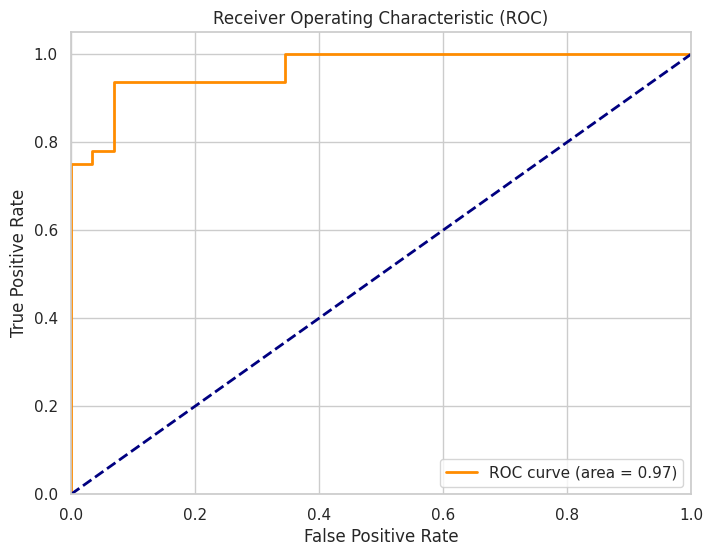

In [45]:
# plotar curva ROC
Y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# área sob a curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

>>> Uma curva ROC quanto mais se aproxima de um "cotovelo" melhor ela é a classificação do modelo. A curva além de estar melhor, também apresenta uma maior área, sendo 1 o maior valor possível.

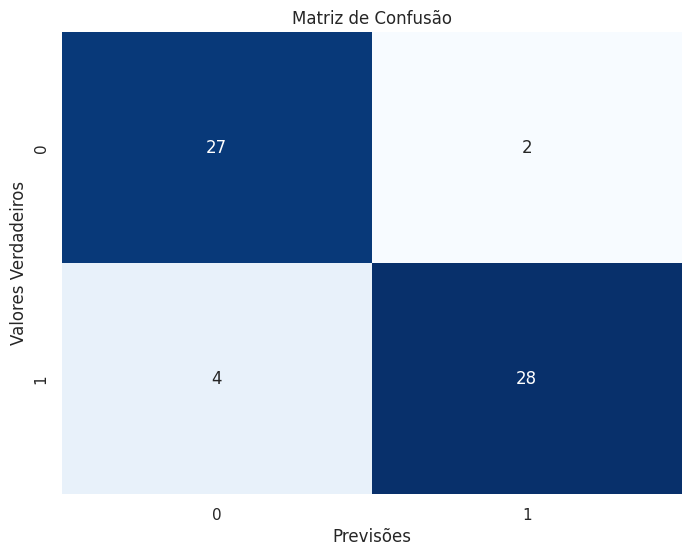

In [46]:
# plot da matriz de confusao
cm = confusion_matrix(Y_test, Y_pred)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.xlabel('Previsões')
plt.ylabel('Valores Verdadeiros')
plt.show()

>>> A matriz de confusão também melhorou, mesmo que pouco, o modelo errou menos como indicado na diagonal segundária.

**`Resposta 2.1`**

A profundidade em que se obtem perfomance máxima no modelo `Random Forest (RF)` estabiliza foi de `1`, sendo menor do que a profundidade em que se obtem perfomance máxima no modelo `Decision Tree (DT)` que é `3`. Esta observação corresponde ao esperado, dadas as diferenças fundamentais entre os dois algoritmos:

1. **Decision Tree (DT)**: Uma única árvore de decisão tende a aprender profundamente a partir dos dados, o que pode levar a um ajuste excessivo (`overfitting) à medida que a profundidade da árvore aumenta`. Uma árvore mais profunda pode capturar mais detalhes dos dados de treino, mas isso também pode fazer com que o modelo aprenda o ruído presente no conjunto de treinamento, prejudicando sua capacidade de generalizar para novos dados.

2. **Random Forest (RF)**: É um ensemble de árvores de decisão. Cada árvore no Random Forest é treinada em uma amostra dos dados (com substituição) e geralmente usa um subconjunto aleatório das características em cada divisão. Essas técnicas de amostragem e subconjunto introduzem `diversidade entre as árvores, o que ajuda a reduzir o overfitting`. Como resultado, `cada árvore individual em um Random Forest não precisa ser tão profunda quanto uma árvore de decisão única para alcançar uma boa performance`, porque o ensemble como um todo é capaz de aprender de forma mais eficaz e generalizar melhor para novos dados.

`**Conclusão**`: A profundidade máxima menor para o Random Forest em comparação com a árvore de decisão única está em linha com o esperado. O Random Forest aproveita o princípio de "sabedoria das massas", onde múltiplas árvores mais simples (e muitas vezes mais curtas) combinam suas previsões para produzir um resultado final que é mais robusto e menos propenso ao overfitting do que uma única árvore profunda. Portanto, uma profundidade máxima menor no Random Forest não apenas é esperada, como também é desejável para manter o equilíbrio entre viés e variância, evitando o overfitting e promovendo uma melhor capacidade de generalização do modelo.

__________________________________________________

## Cenarios RF

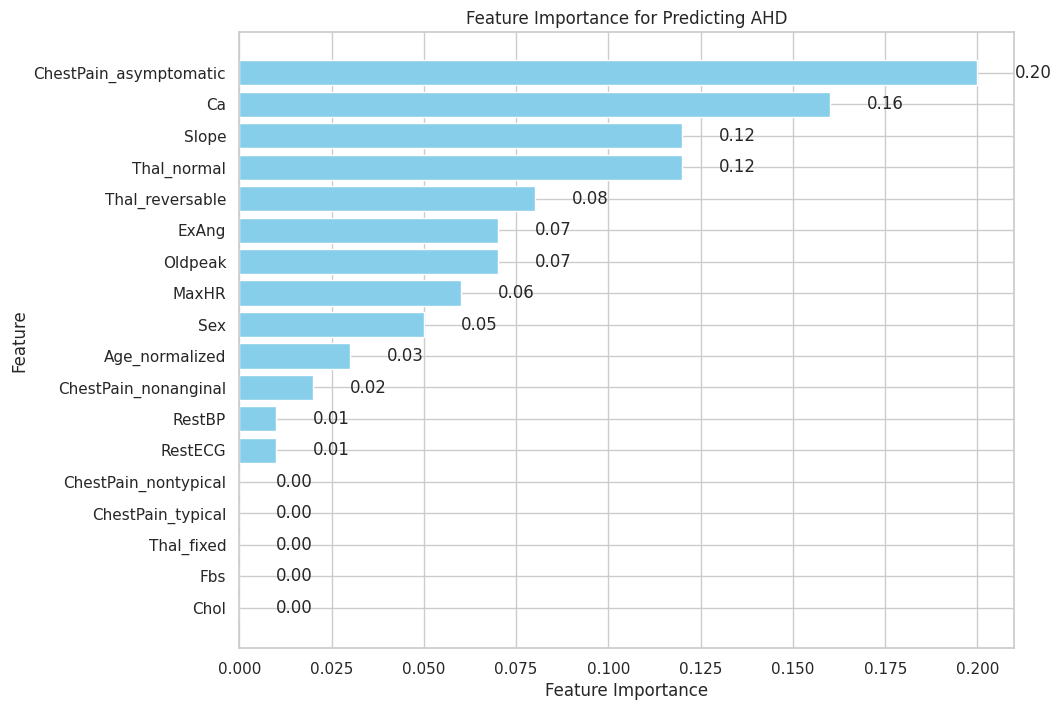

In [47]:
# importância das características do modelo treinado
feature_importances = rf_model.feature_importances_

# importância das características com os nomes das colunas
features = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot
plt.figure(figsize=(10, 8))
bars = plt.barh(feature_importance_sorted['Feature'], feature_importance_sorted['Importance'], color='skyblue')

# add valores
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01,
             bar.get_y() + bar.get_height() / 2,
             '{:.2f}'.format(width),
             va='center')

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Predicting AHD')
plt.gca().invert_yaxis()
plt.show()

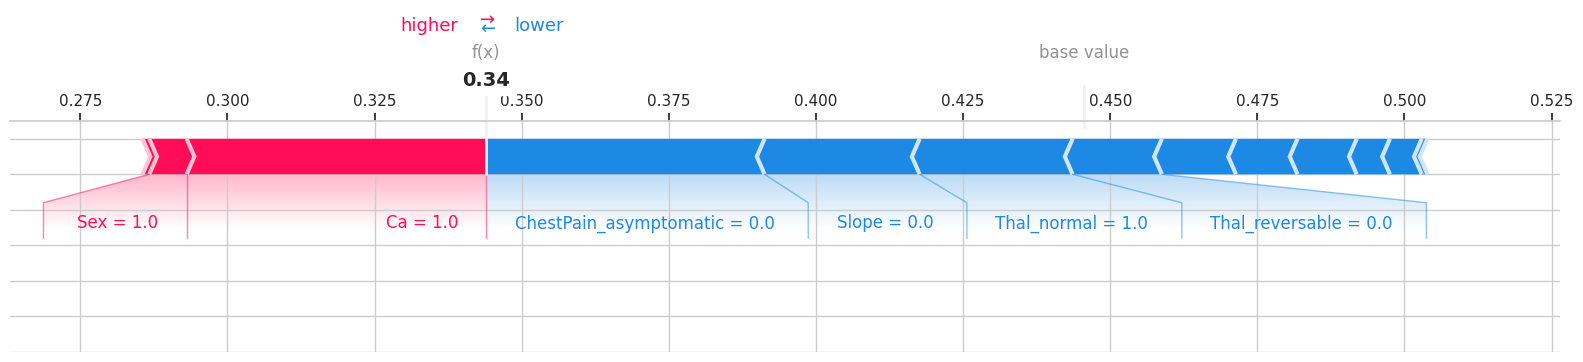

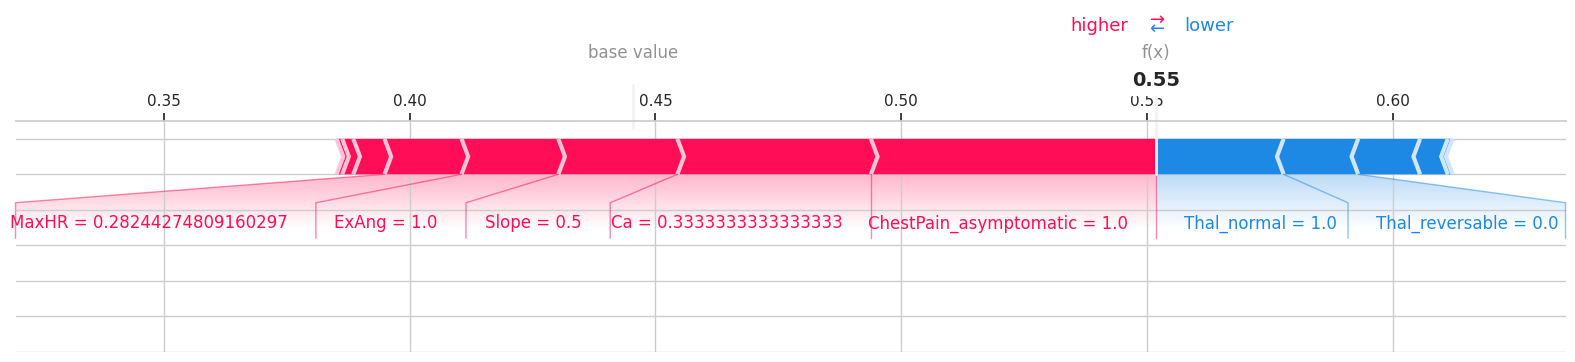

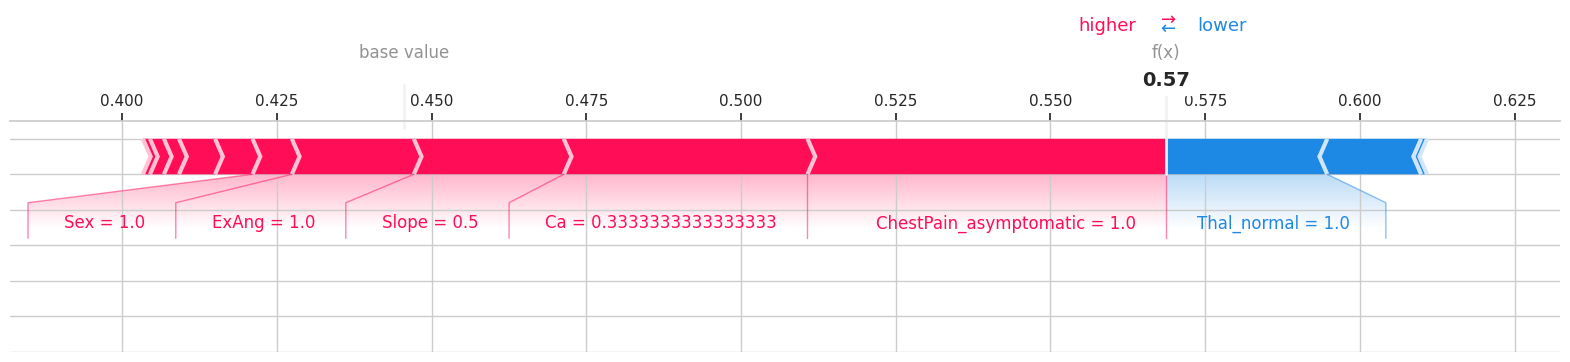

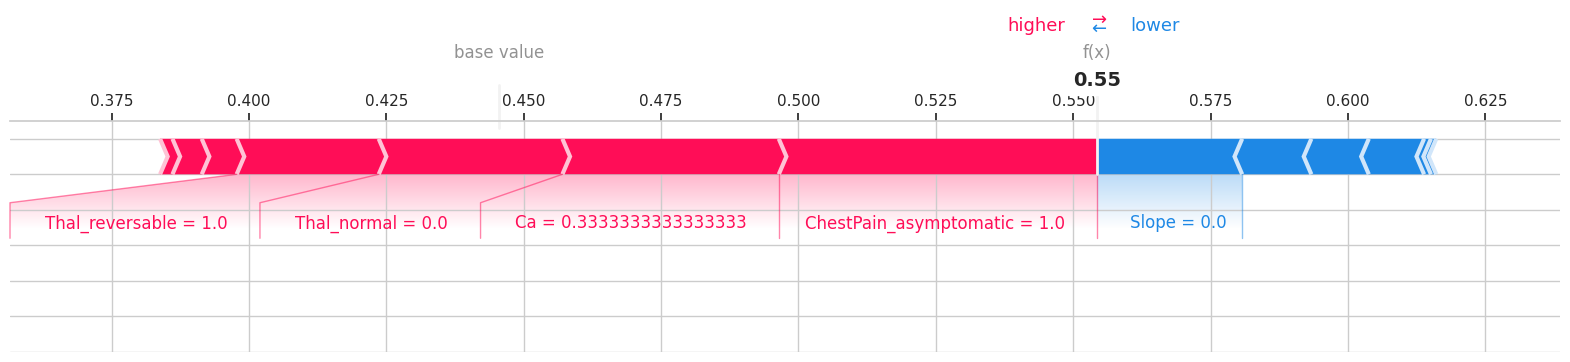

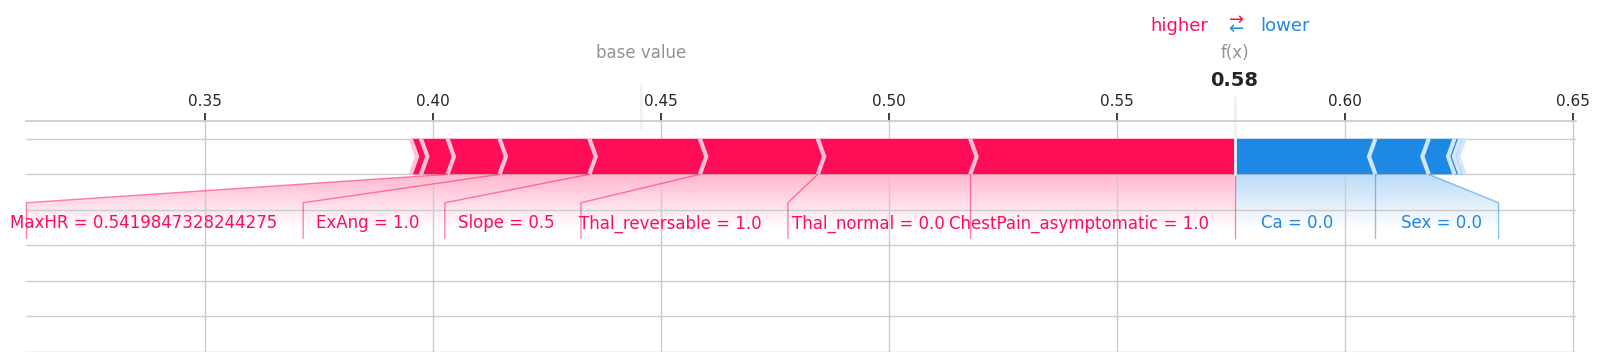

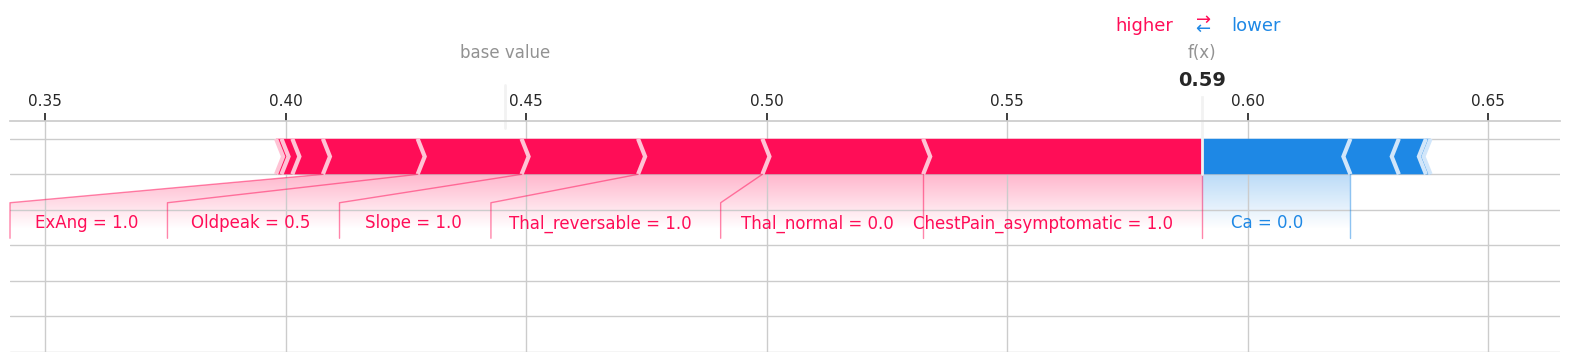

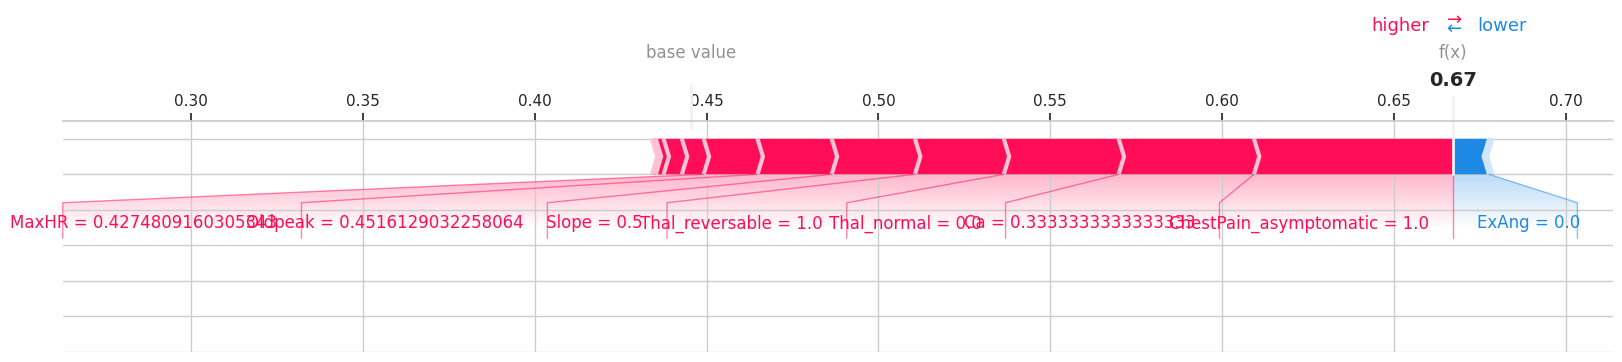

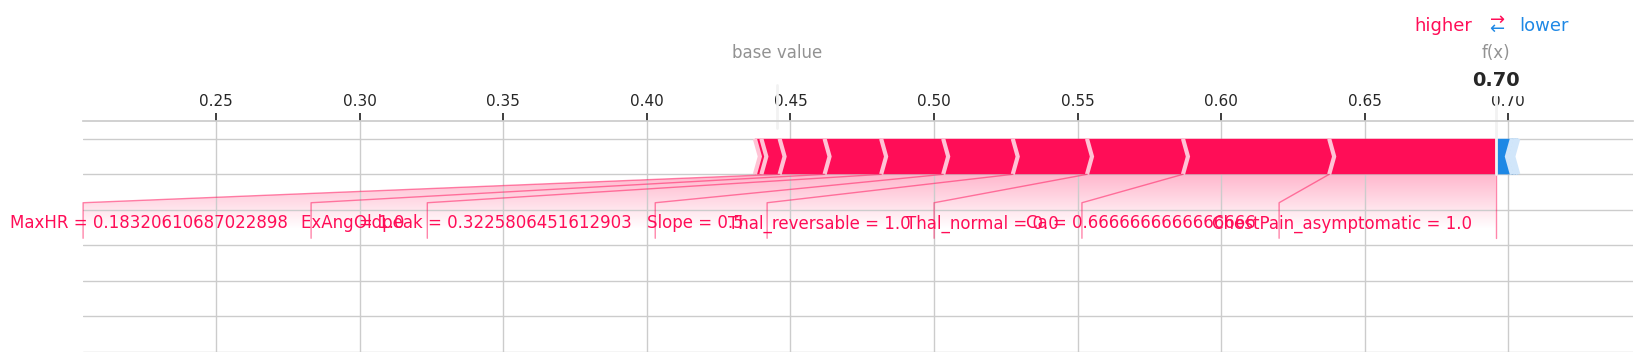

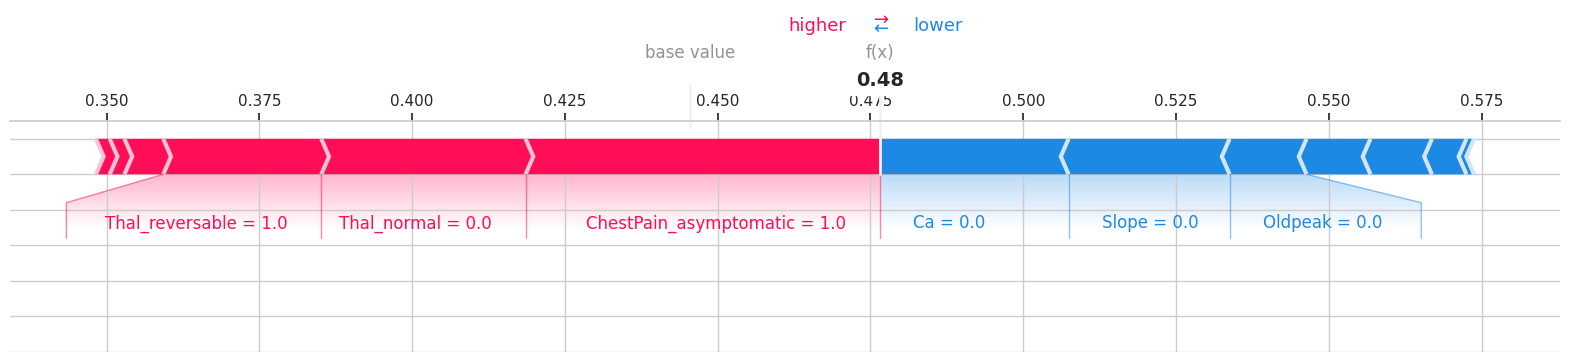

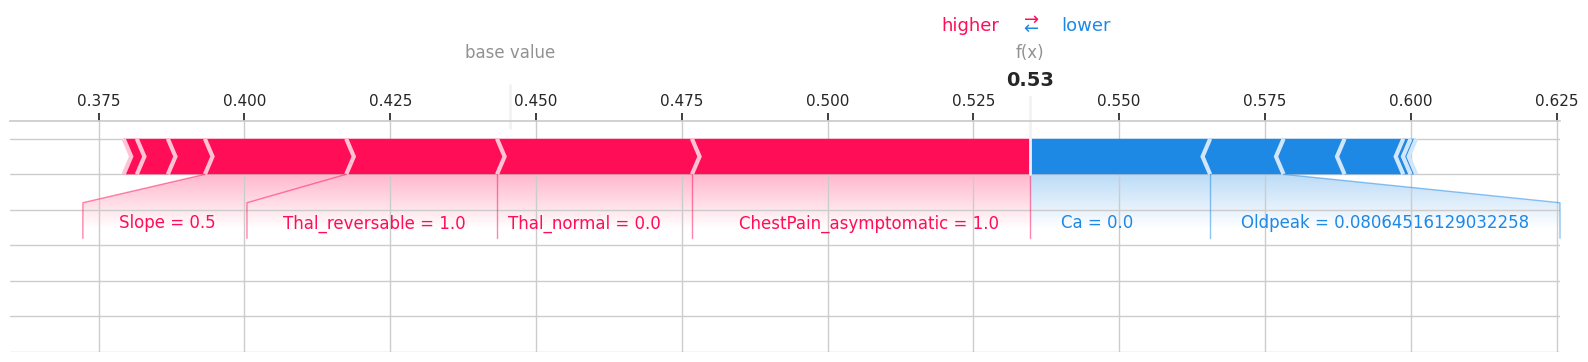

In [60]:
explainer = shap.TreeExplainer(rf_model)

# Calcular SHAP
shap_values = explainer.shap_values(X_test)

index = 2 # indice para escolher
shap.initjs()
#shap.force_plot(explainer.expected_value[1], shap_values[1][index], X_test.iloc[index])
for i in range(10):
    shap.force_plot(
        explainer.expected_value[1], shap_values[1][i],
        X_test.iloc[i], show=False, matplotlib=True
    )
    plt.show()

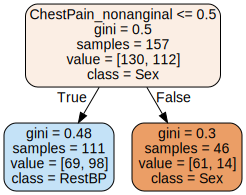

In [59]:
# plot a random forest
estimator = rf_model.estimators_[0]
export_graphviz(estimator, out_file='tree.dot',
                feature_names = X_train.columns,
                class_names = X.columns,
                rounded = True, proportion = False,
                precision = 2, filled = True)
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

**`Resposta 2.2`** - O modelo Random Forest, ao contrário da Decision Tree, considerou um elevado número de características para a tomada de decisão. Enquanto a DT considerou apenas 6 features como as principais, a RF encontrou 13 features, mesmo que o impacto tenha sido baixo, sendo as mais importantes:

* chestpain (assim como para DT)
* ca (assim como para DT)
* slope
* thal (assim como para DT)
* idade
* ang
* maxhr
* sexo
* idade (assim como para DT)


Ao observarmos os critérios de decisão na imagem da árvore, notamos que, novamente, se o paciente apresenta dores no peito, já há grandes indícios de um diagnóstico positivo. Também observamos que, de acordo com nosso modelo, mulheres têm mais chances de serem diagnosticadas. A característica thal = 0, chol < 0.37, CA < 0.17 e chol < 0.32 também são fortes condições que favorecem o diagnóstico positivo do paciente.

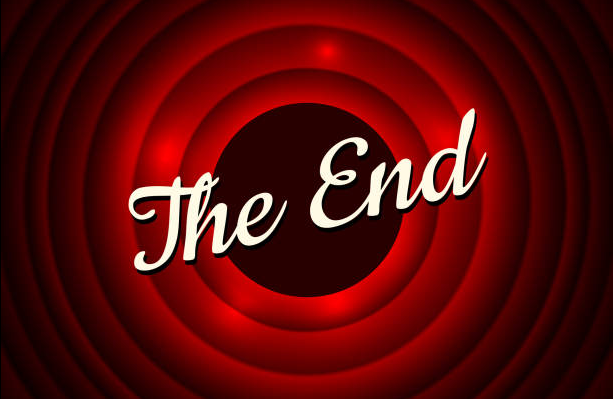